In [2]:
import pandas as pd
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
# Preprocessing
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from itertools import combinations
from sklearn.decomposition import PCA
# Evaluation
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
# Scores
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
from sklearn.svm import LinearSVR
# from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

## Loading Superconductors dataset

In [3]:
df = pd.read_csv('superconductors.csv')

## Exploratory Data Analysis

Missing and categorical data

In [3]:
print('The data dimensionality is: ', df.shape, '\nAttributes:', df.columns)
print('Missing data:\n', df.isnull().sum())
print(df.describe())
# df.describe().to_excel('data.xlsx')
print(df.dtypes)

The data dimensionality is:  (21263, 82) 
Attributes: Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_Electron

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Target variable distribution')

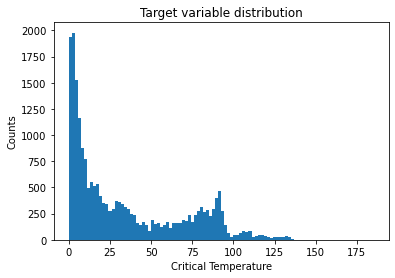

In [4]:
print(df['critical_temp'].hist(bins=100, grid=False))
plt.xlabel('Critical Temperature')
plt.ylabel('Counts')
plt.title('Target variable distribution')
#plt.savefig('critical_temp.png', dpi=300)

#### Scatter Plot Matrix and Heat Map between properties of the same feature

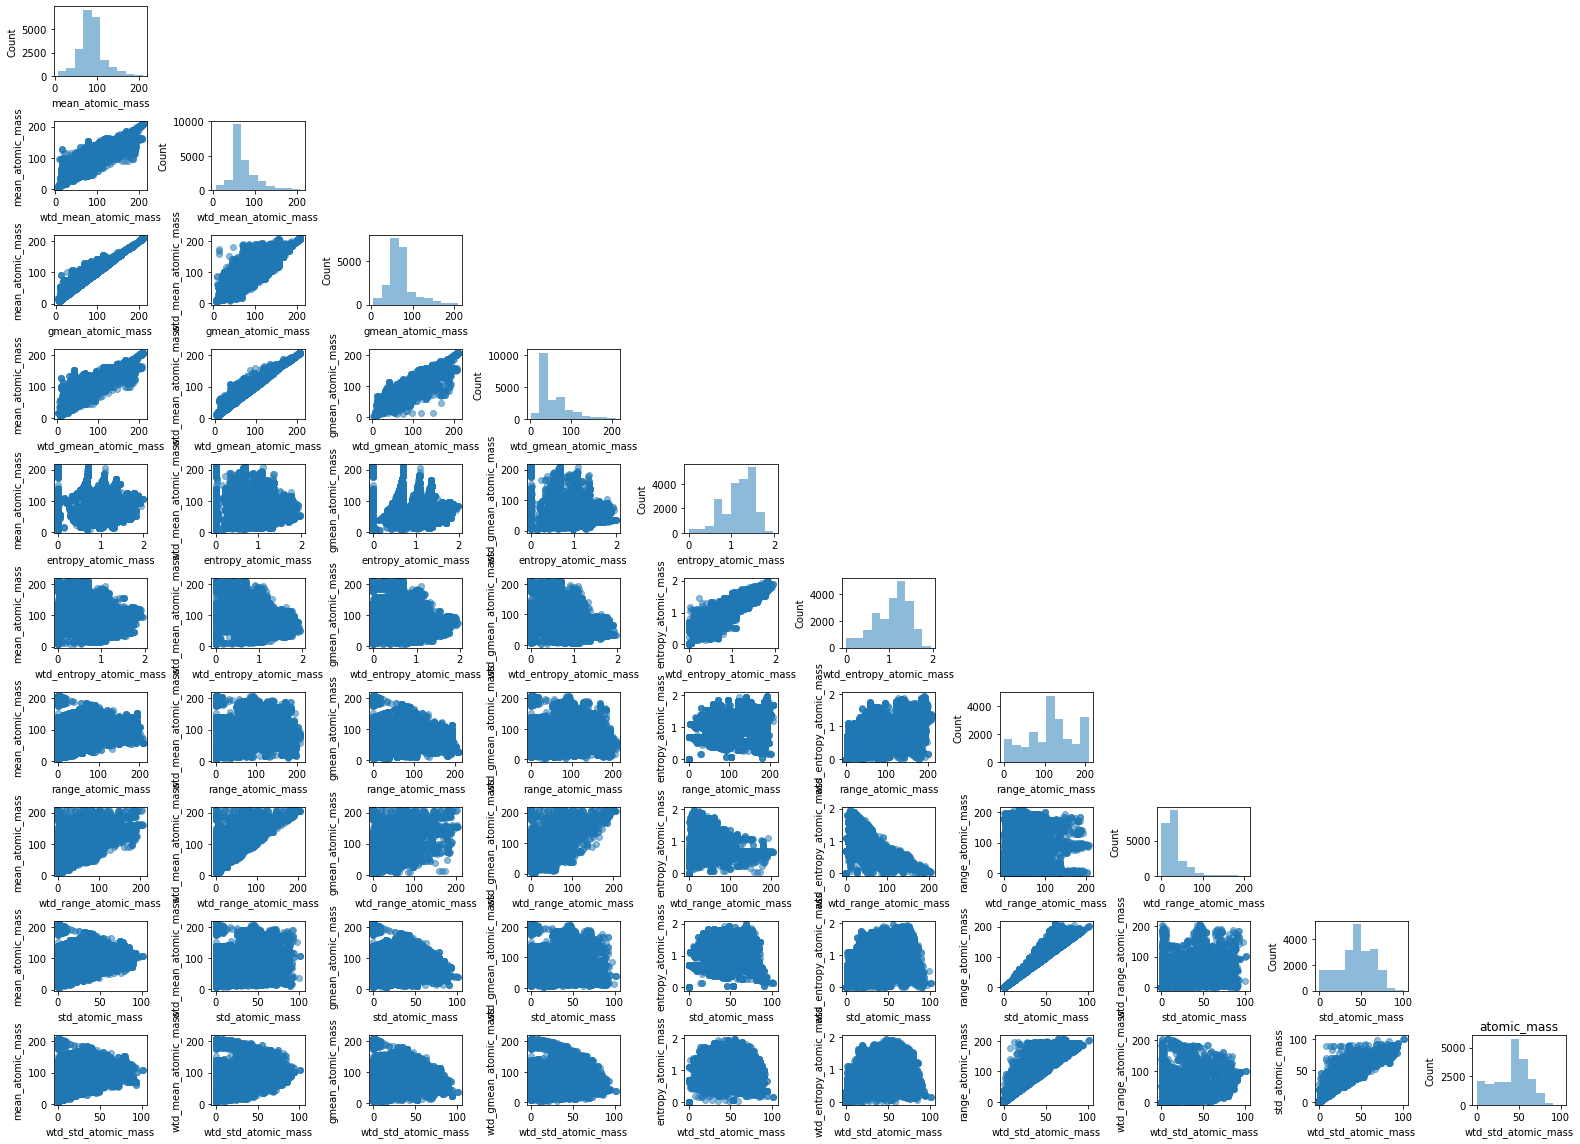

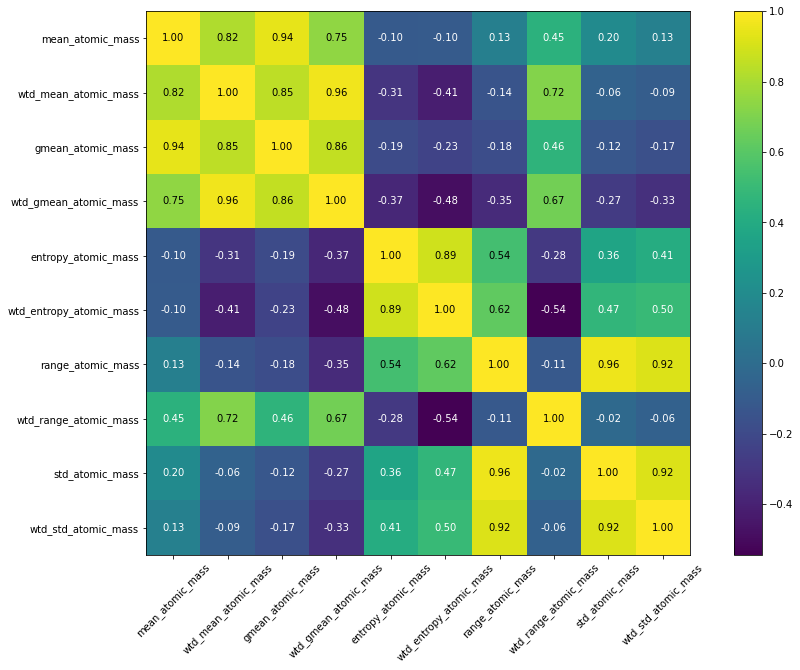

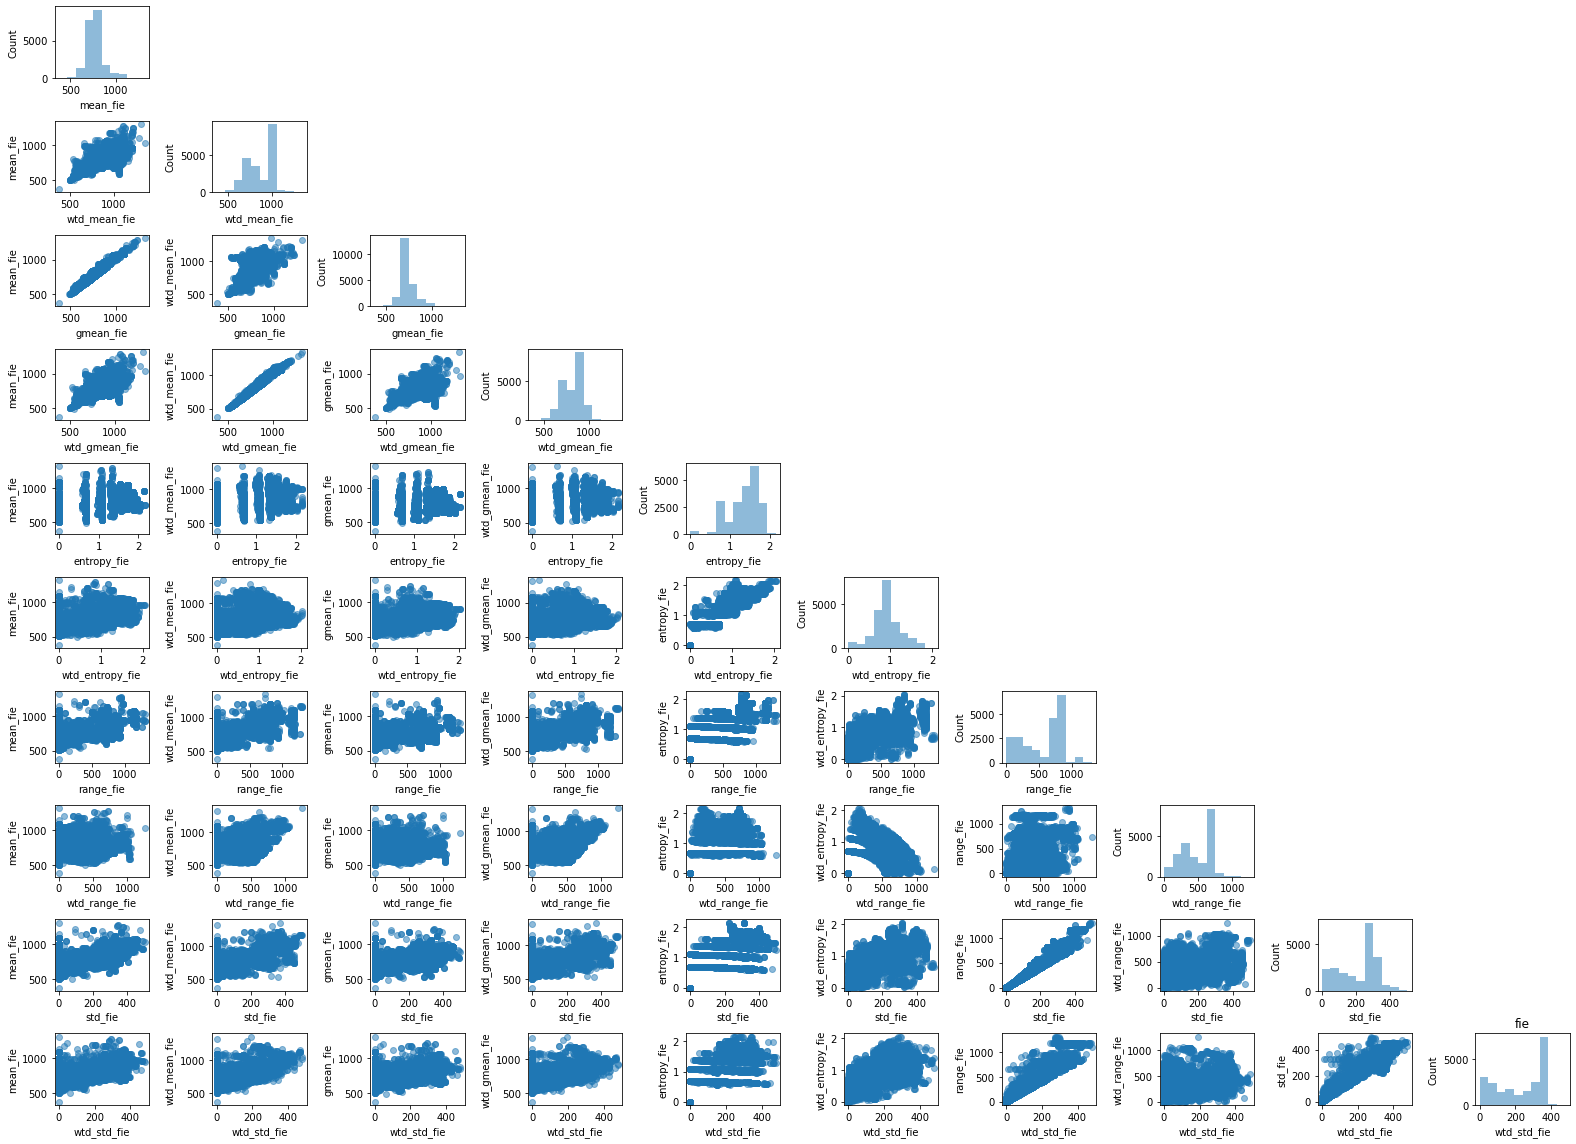

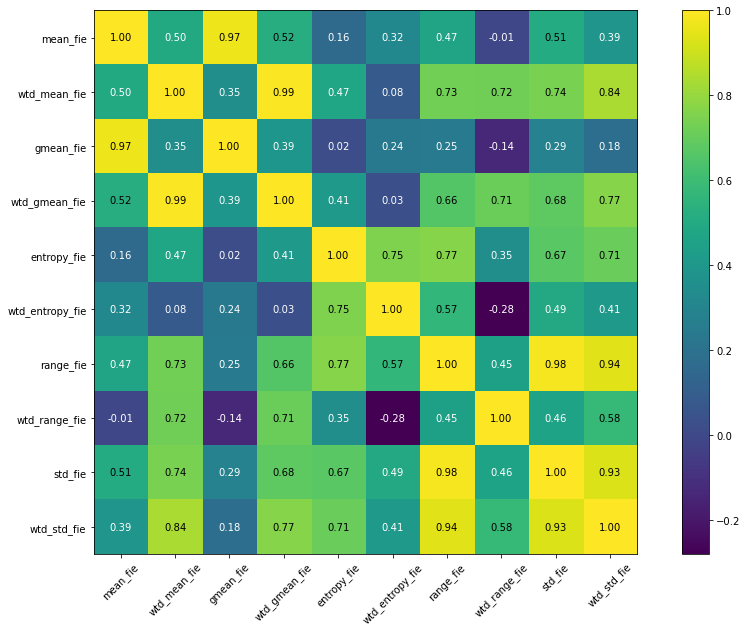

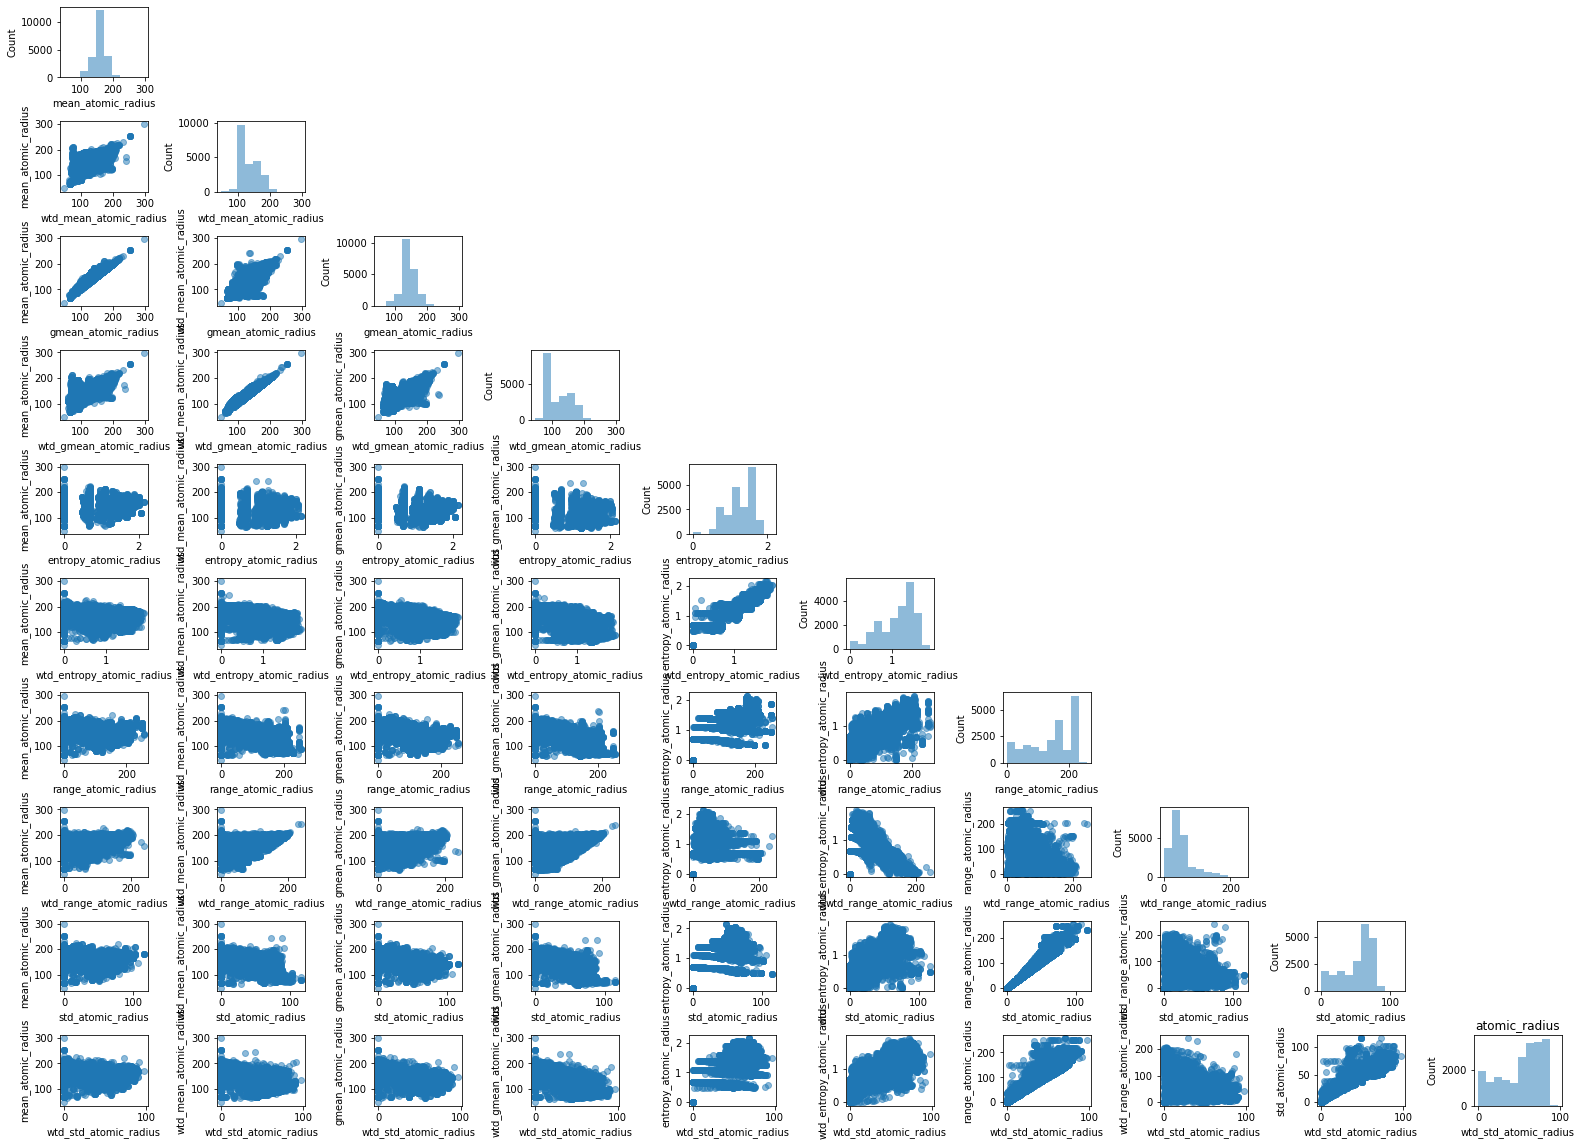

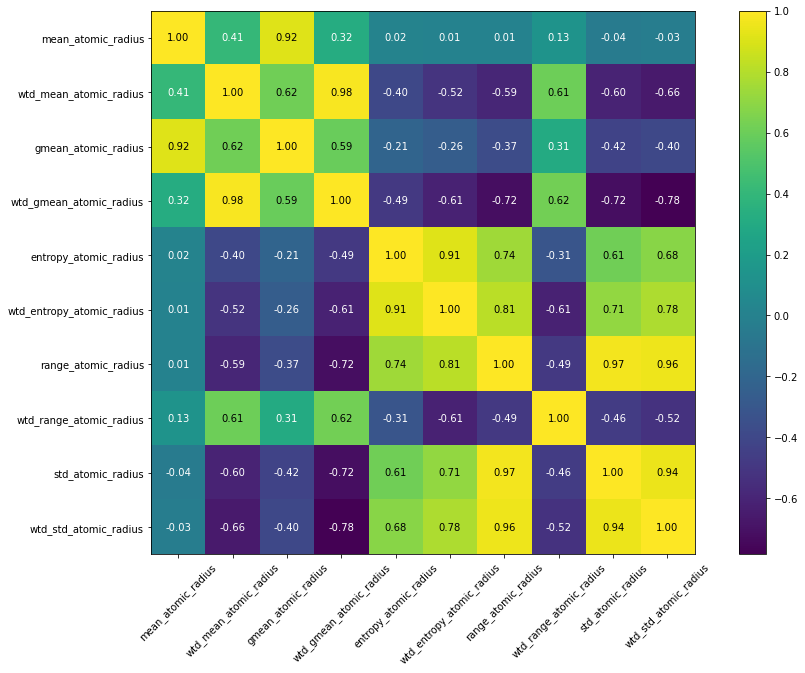

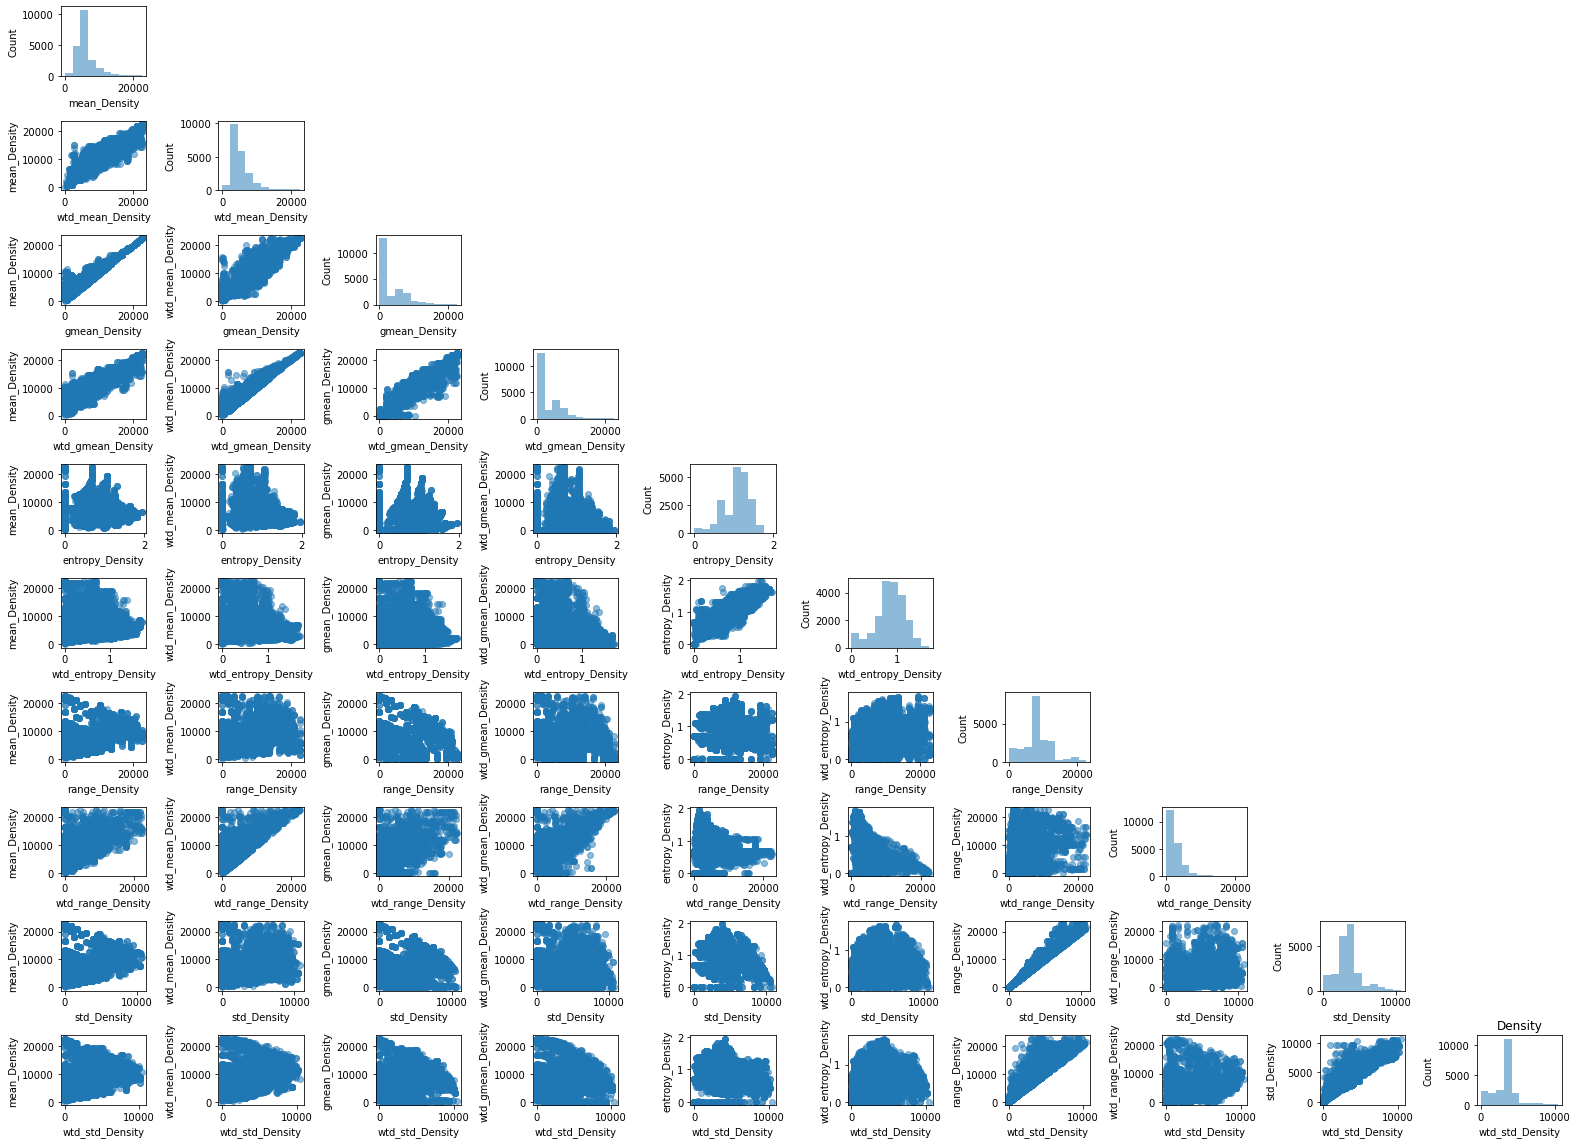

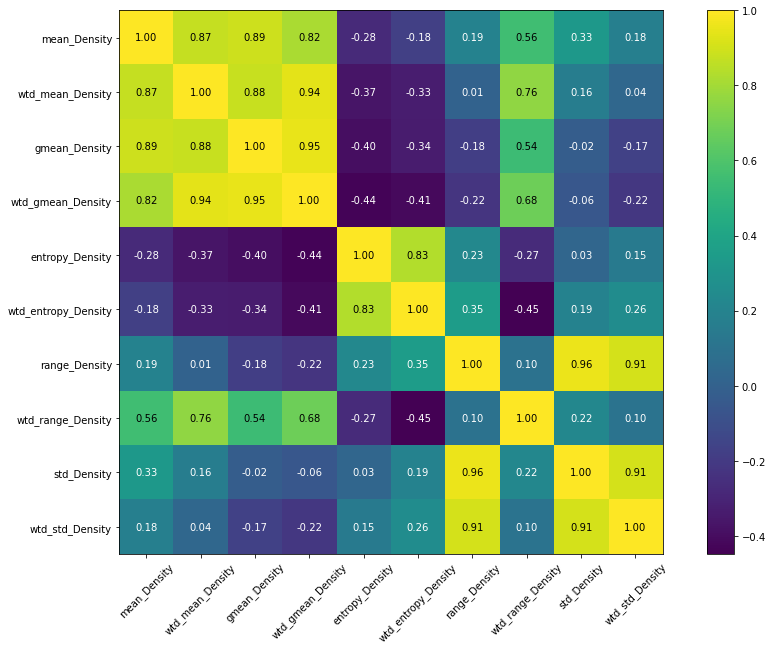

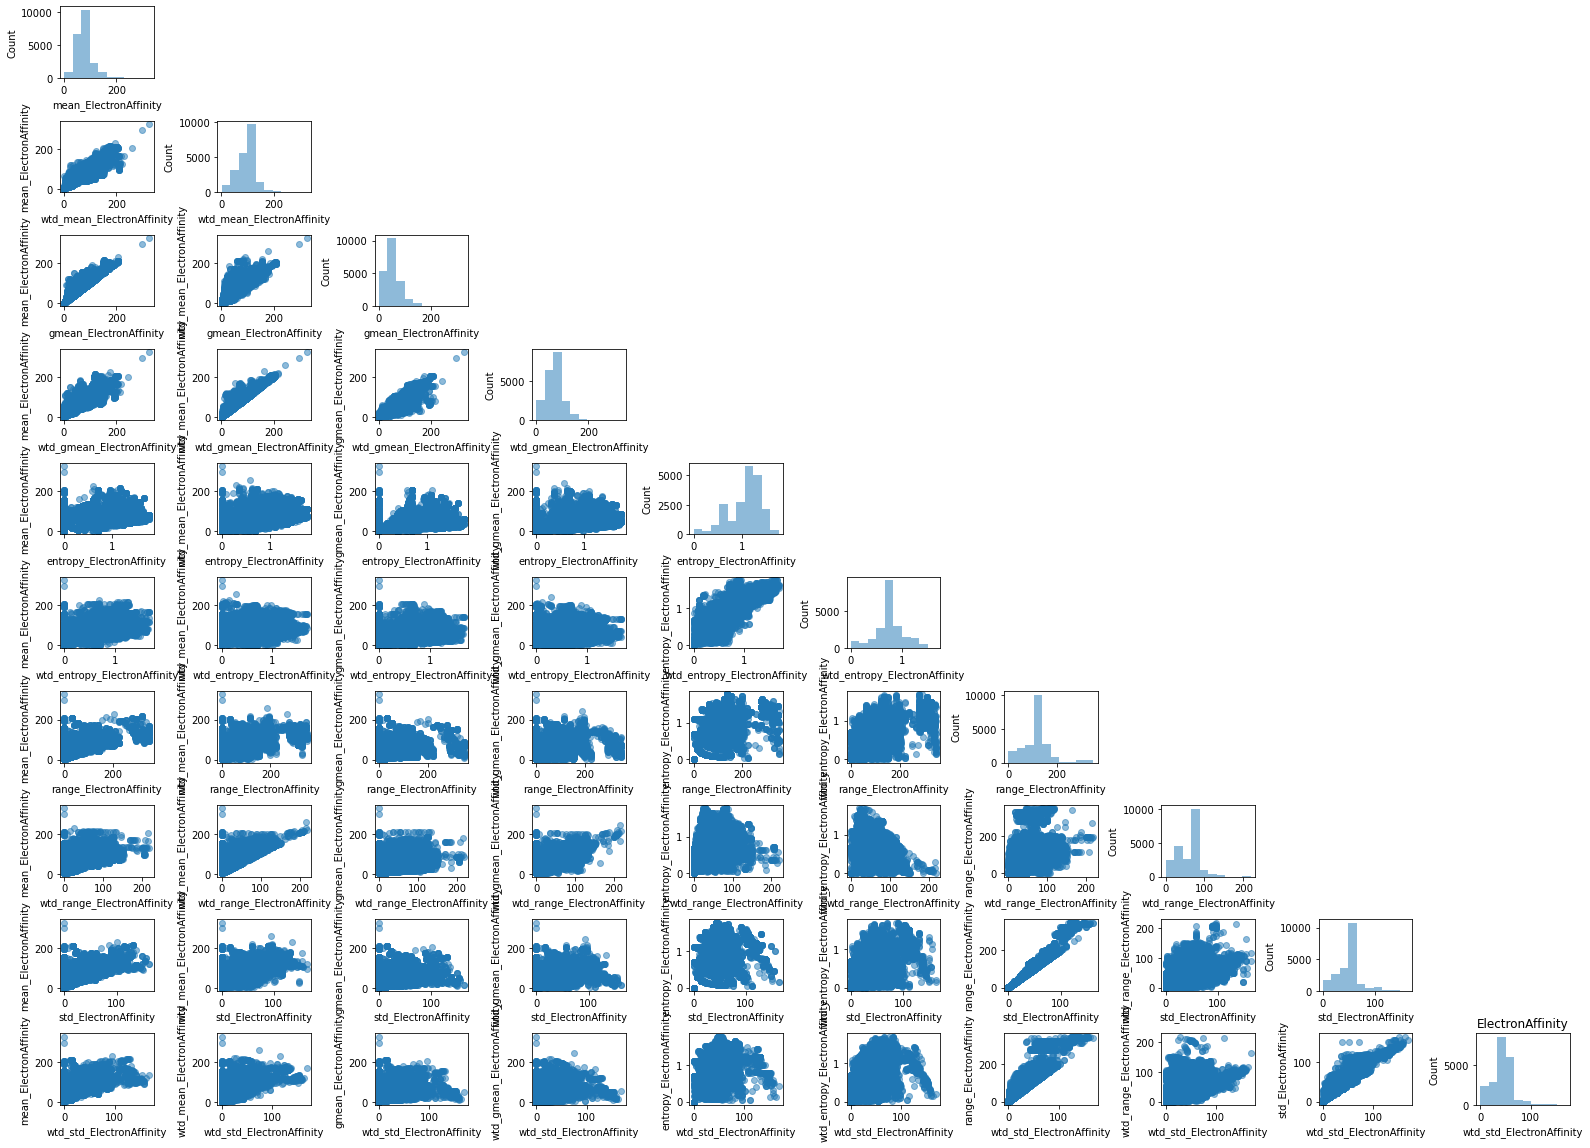

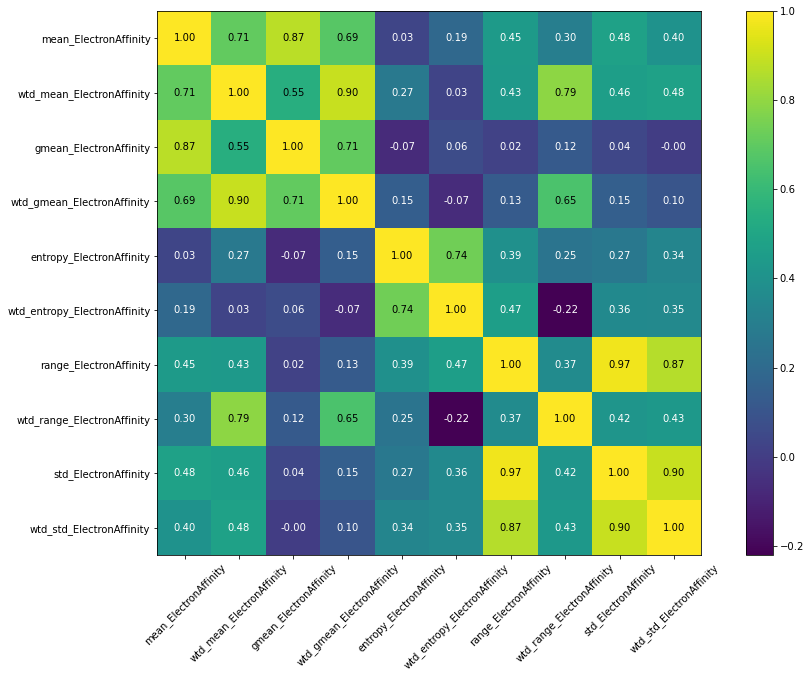

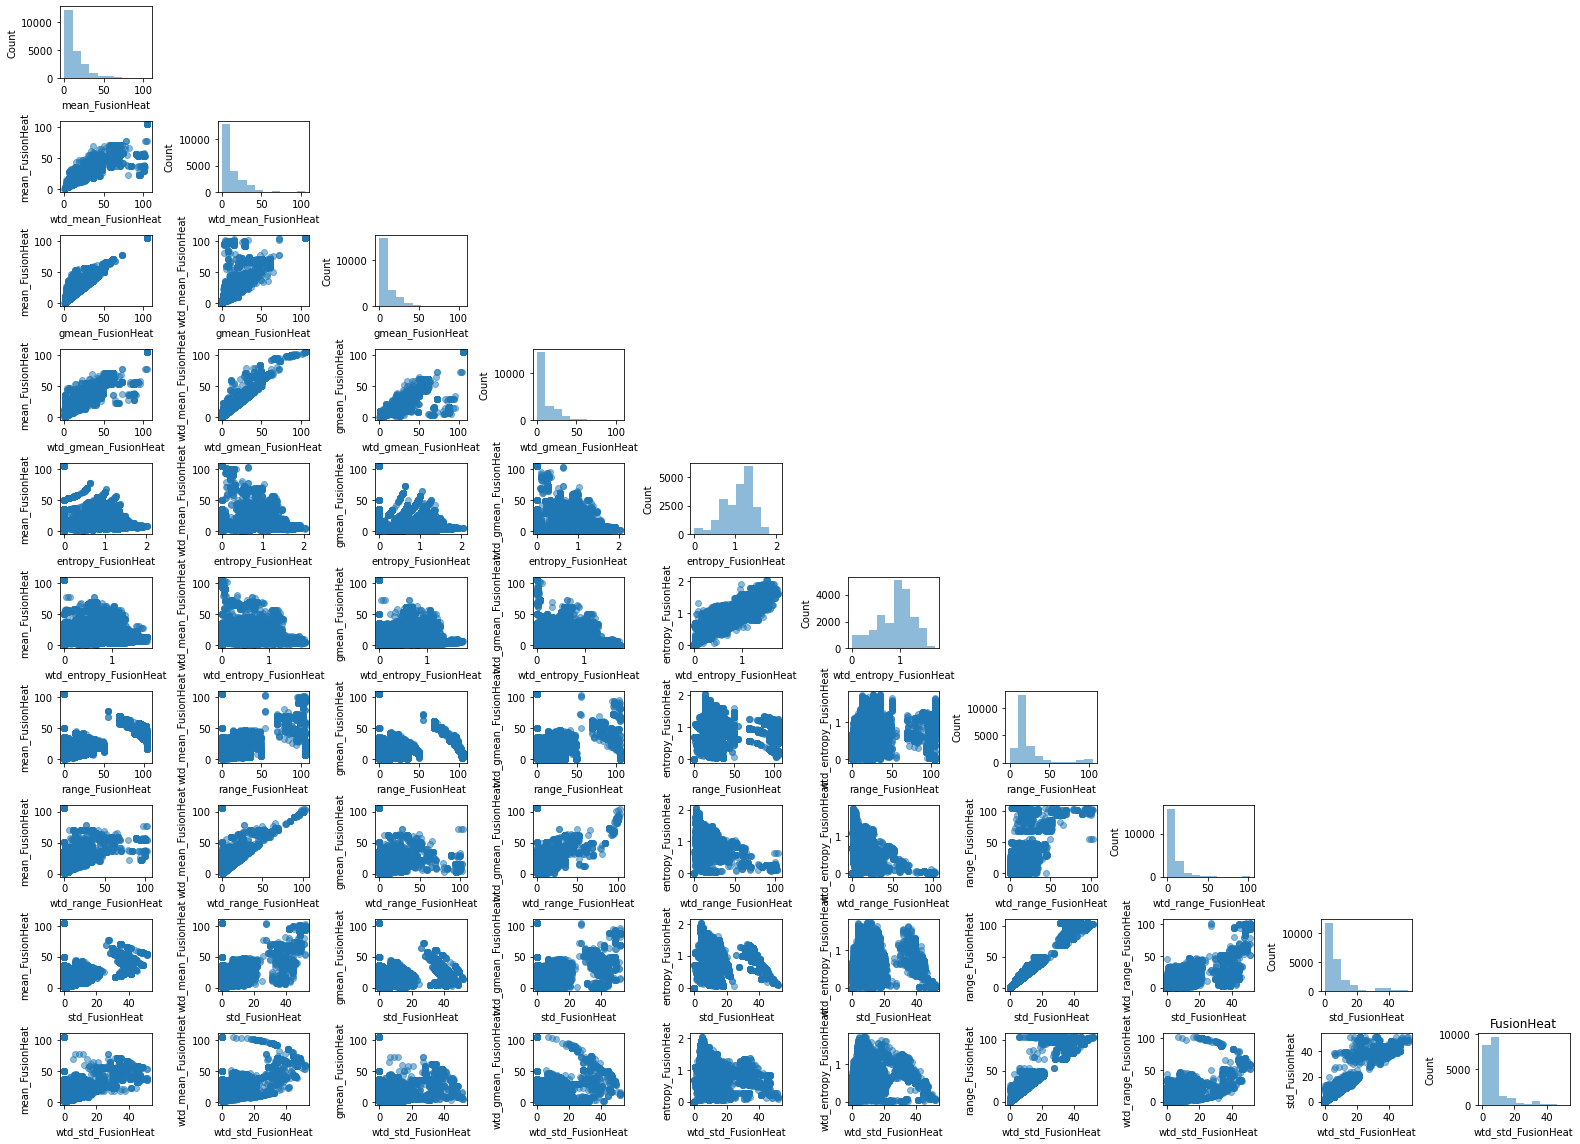

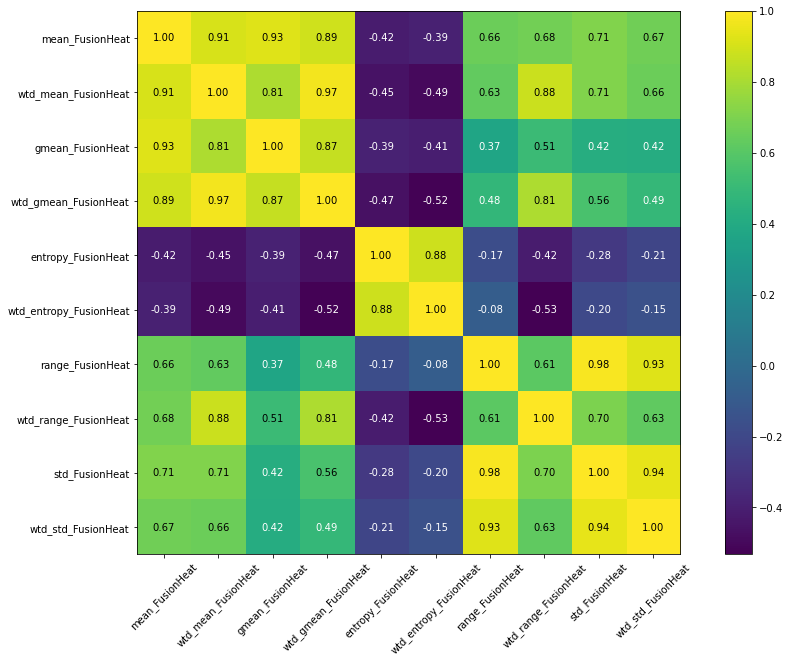

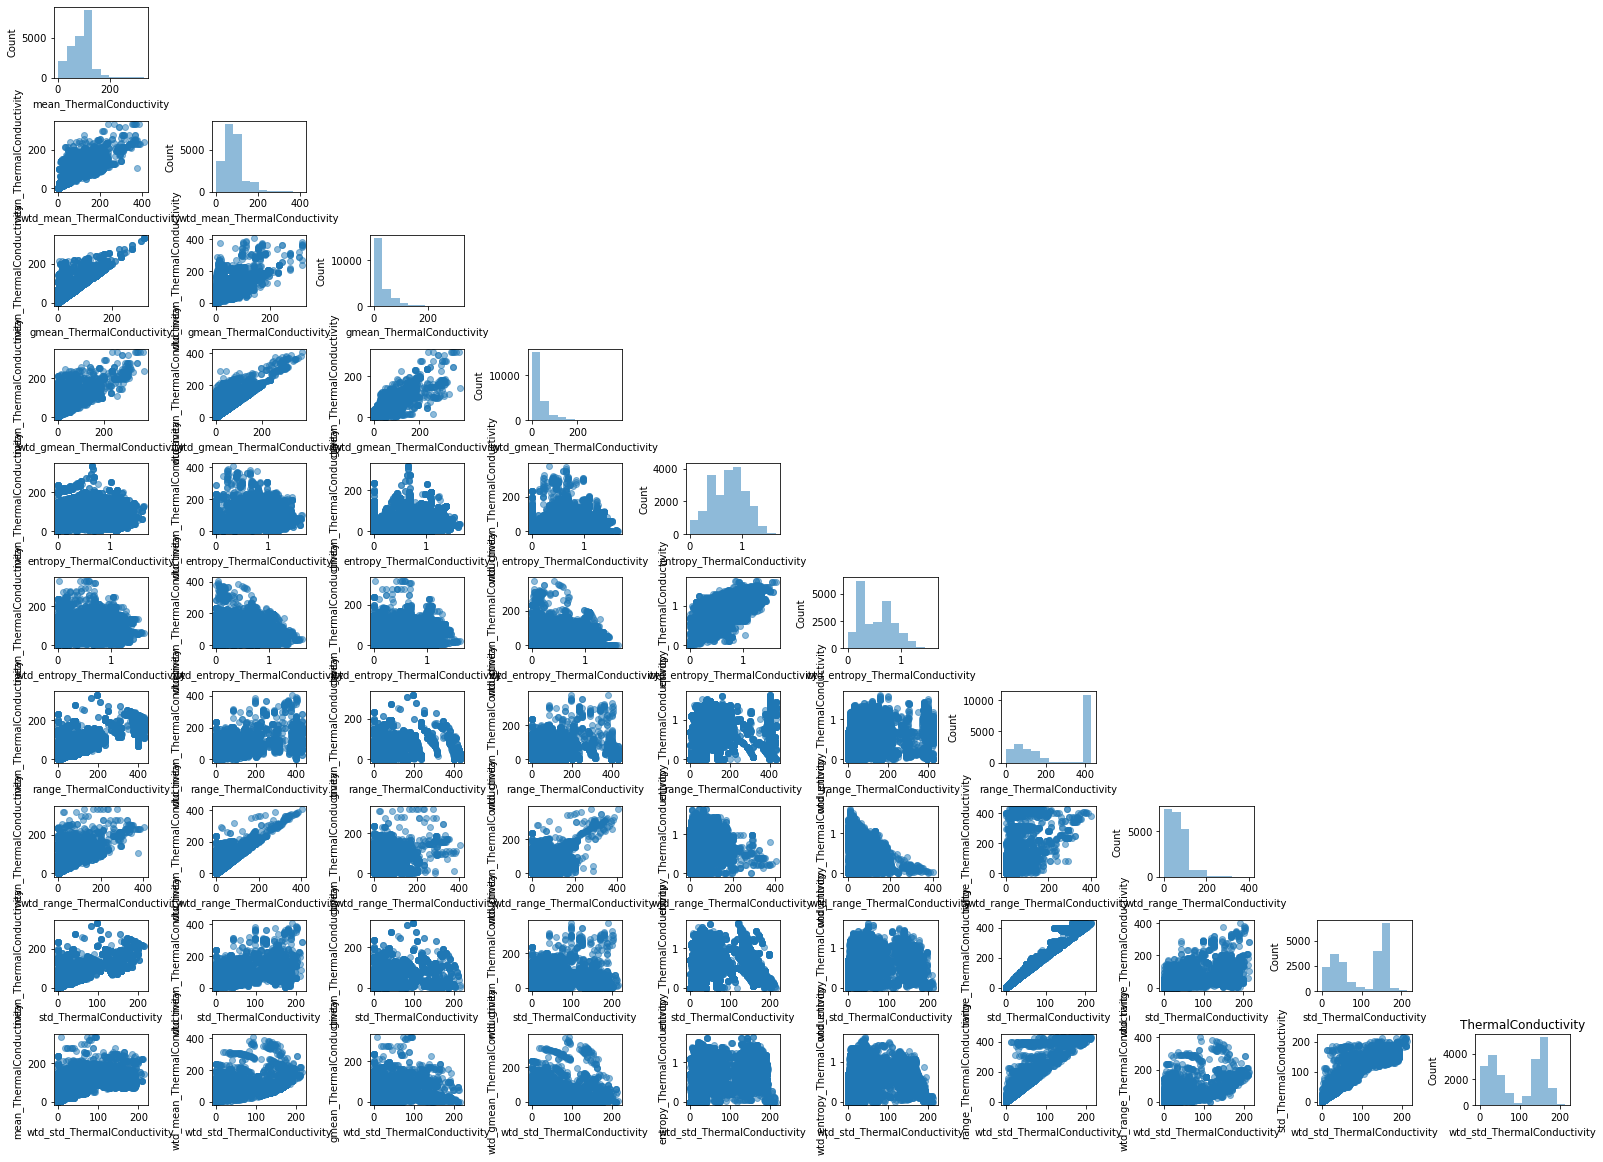

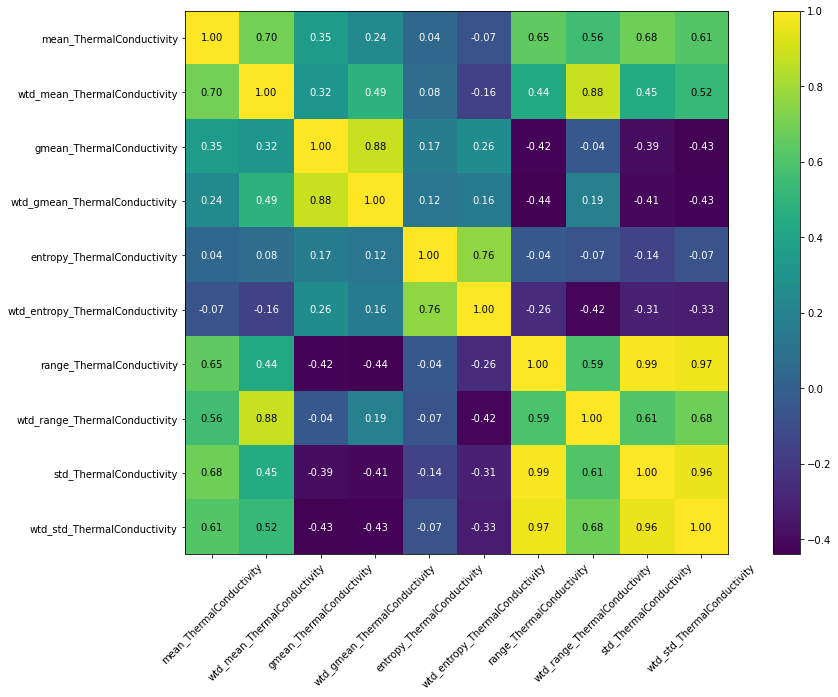

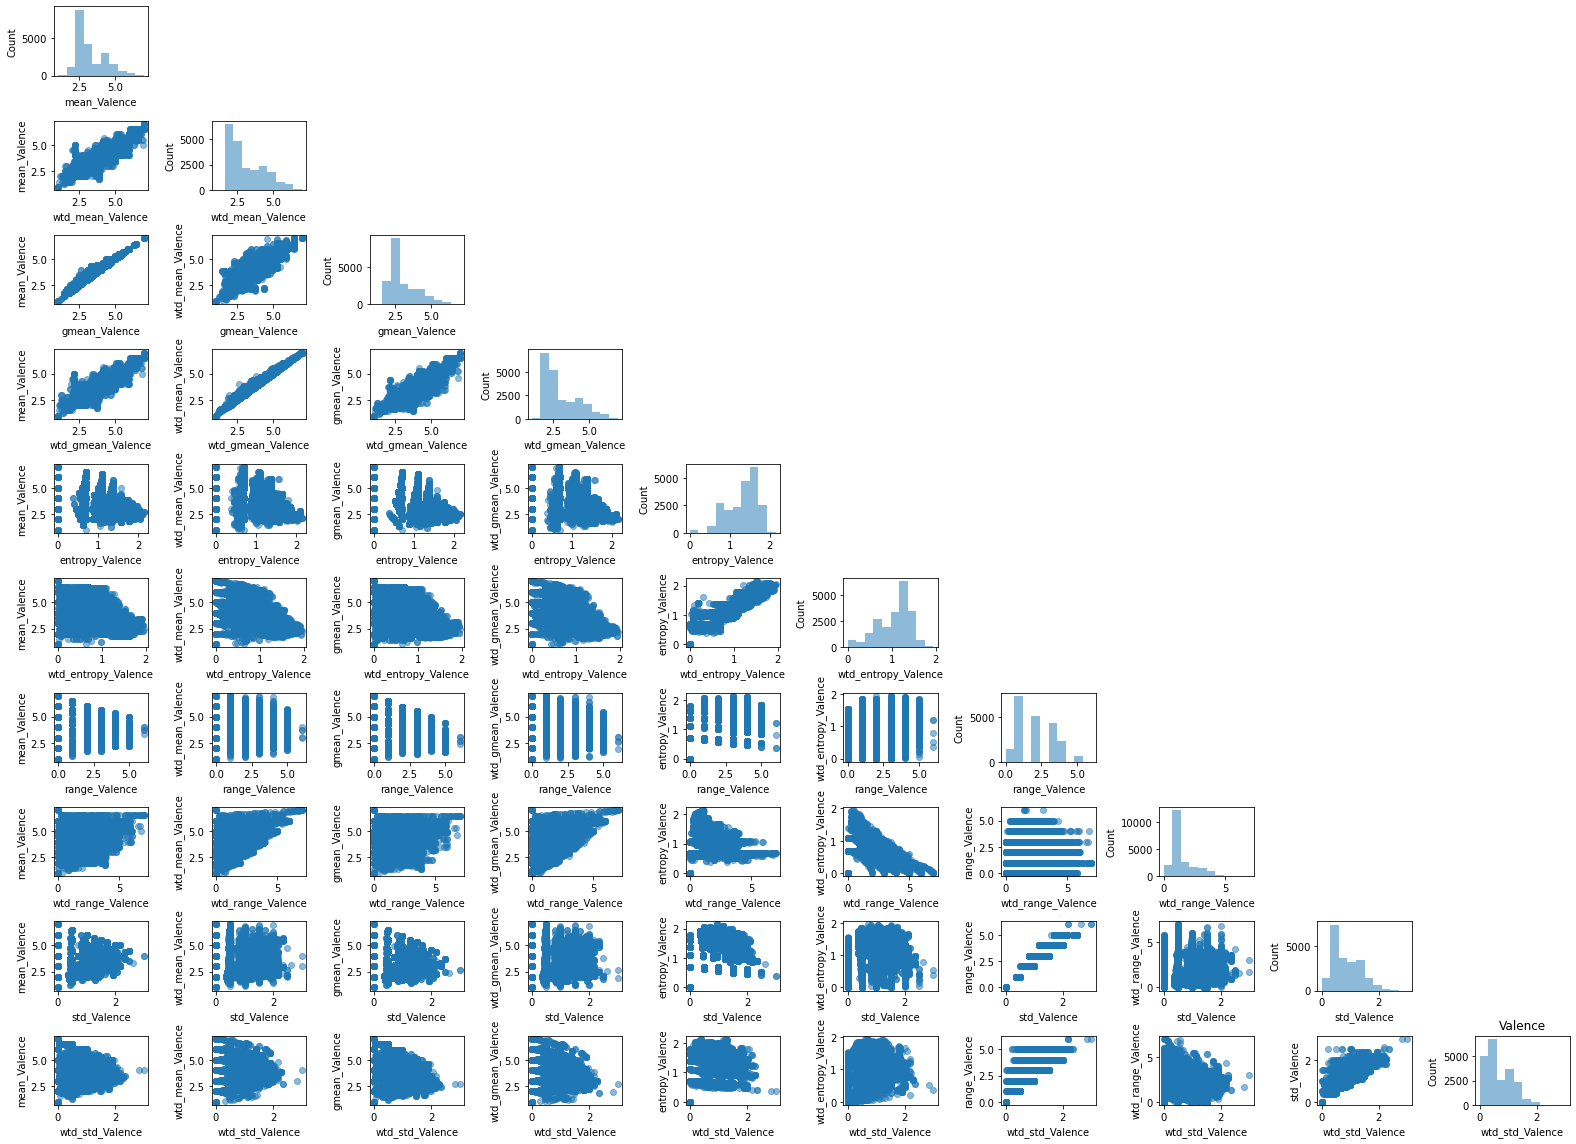

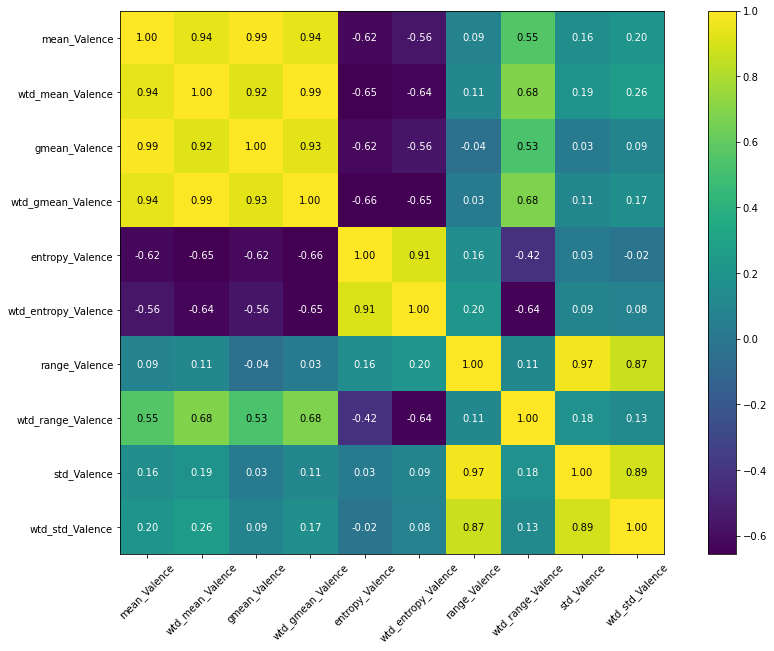

In [5]:
n_feature = 8
n_stat_feature = 10
feature_name = ['atomic_mass','fie','atomic_radius', 'Density', 'ElectronAffinity',
                'FusionHeat','ThermalConductivity','Valence']
stat_name = ['mean', 'wtd_mean', 'gmean', 'wtd_gmean', 'entropy','wtd_entropy',
             'range', 'wtd_range', 'std', 'wtd_std']
feature = []
for i in range(n_feature):
    names = df.columns[1+i*n_stat_feature:1+(i+1)*n_stat_feature]
    feature.append(df[names])
    scatterplotmatrix(feature[i].values, figsize=(22, 16), names=names, alpha=0.5)
    plt.tight_layout()
    plt.title(feature_name[i])
    #plt.savefig('SPM_'+feature_name[i]+'.png', dpi=300)
    plt.show()
    #HEATMAP
    cm = np.corrcoef(feature[i].values.T)
    hm = heatmap(cm, row_names=names, column_names=names, figsize=(16, 10))
    #plt.savefig('HM_'+feature_name[i]+'.png', dpi=300)
    plt.show()
    del names

#### Scatter Plot Matrix and Hot map between feature

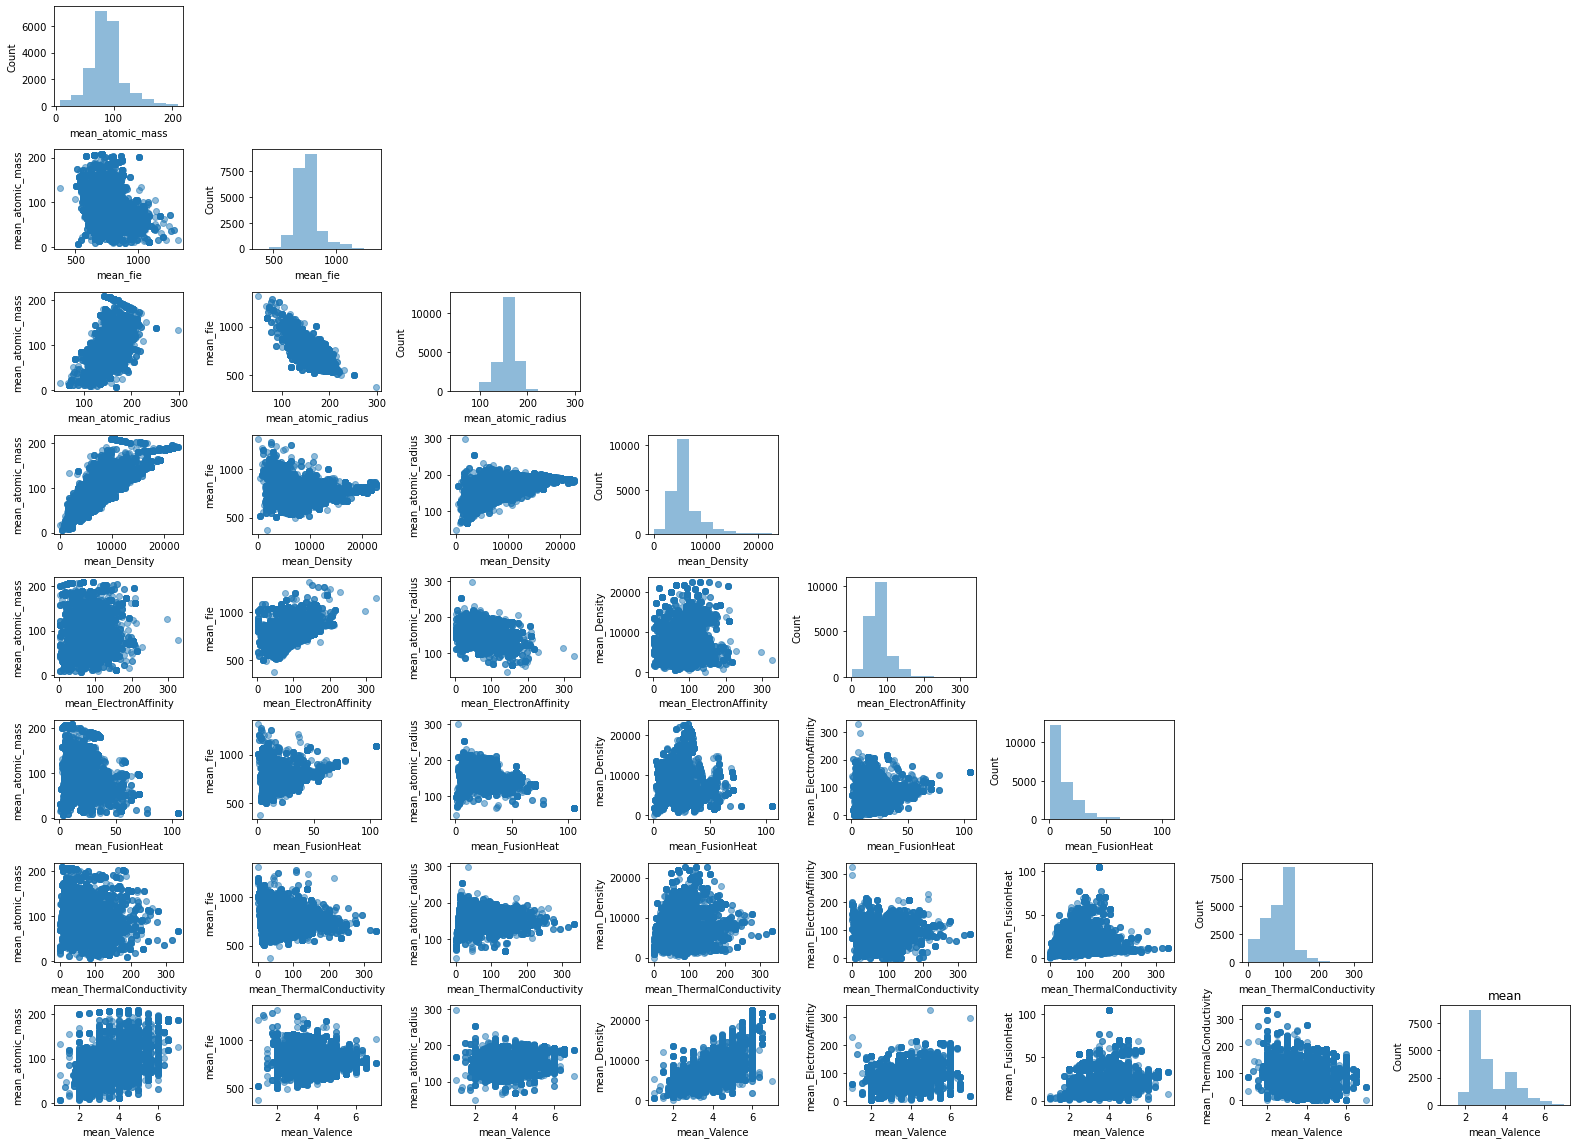

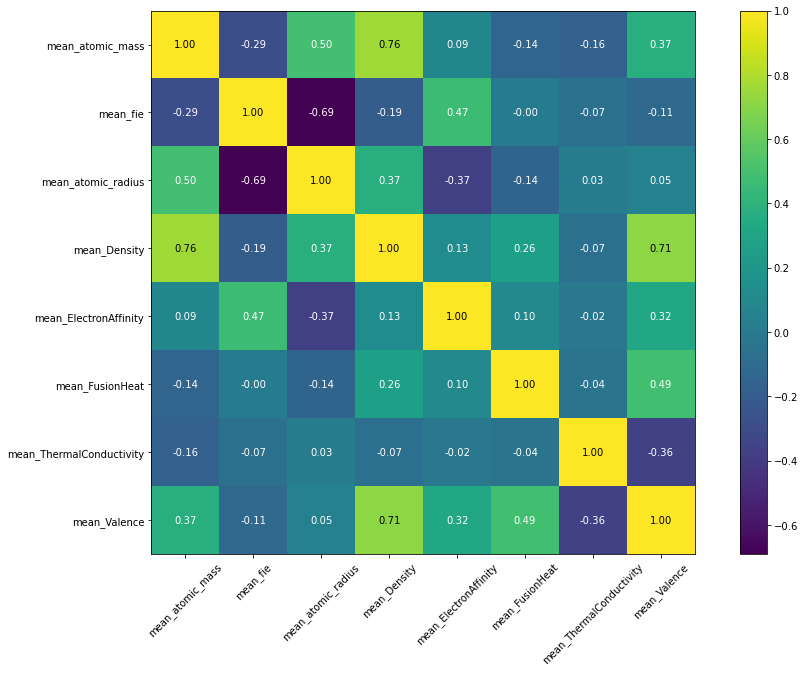

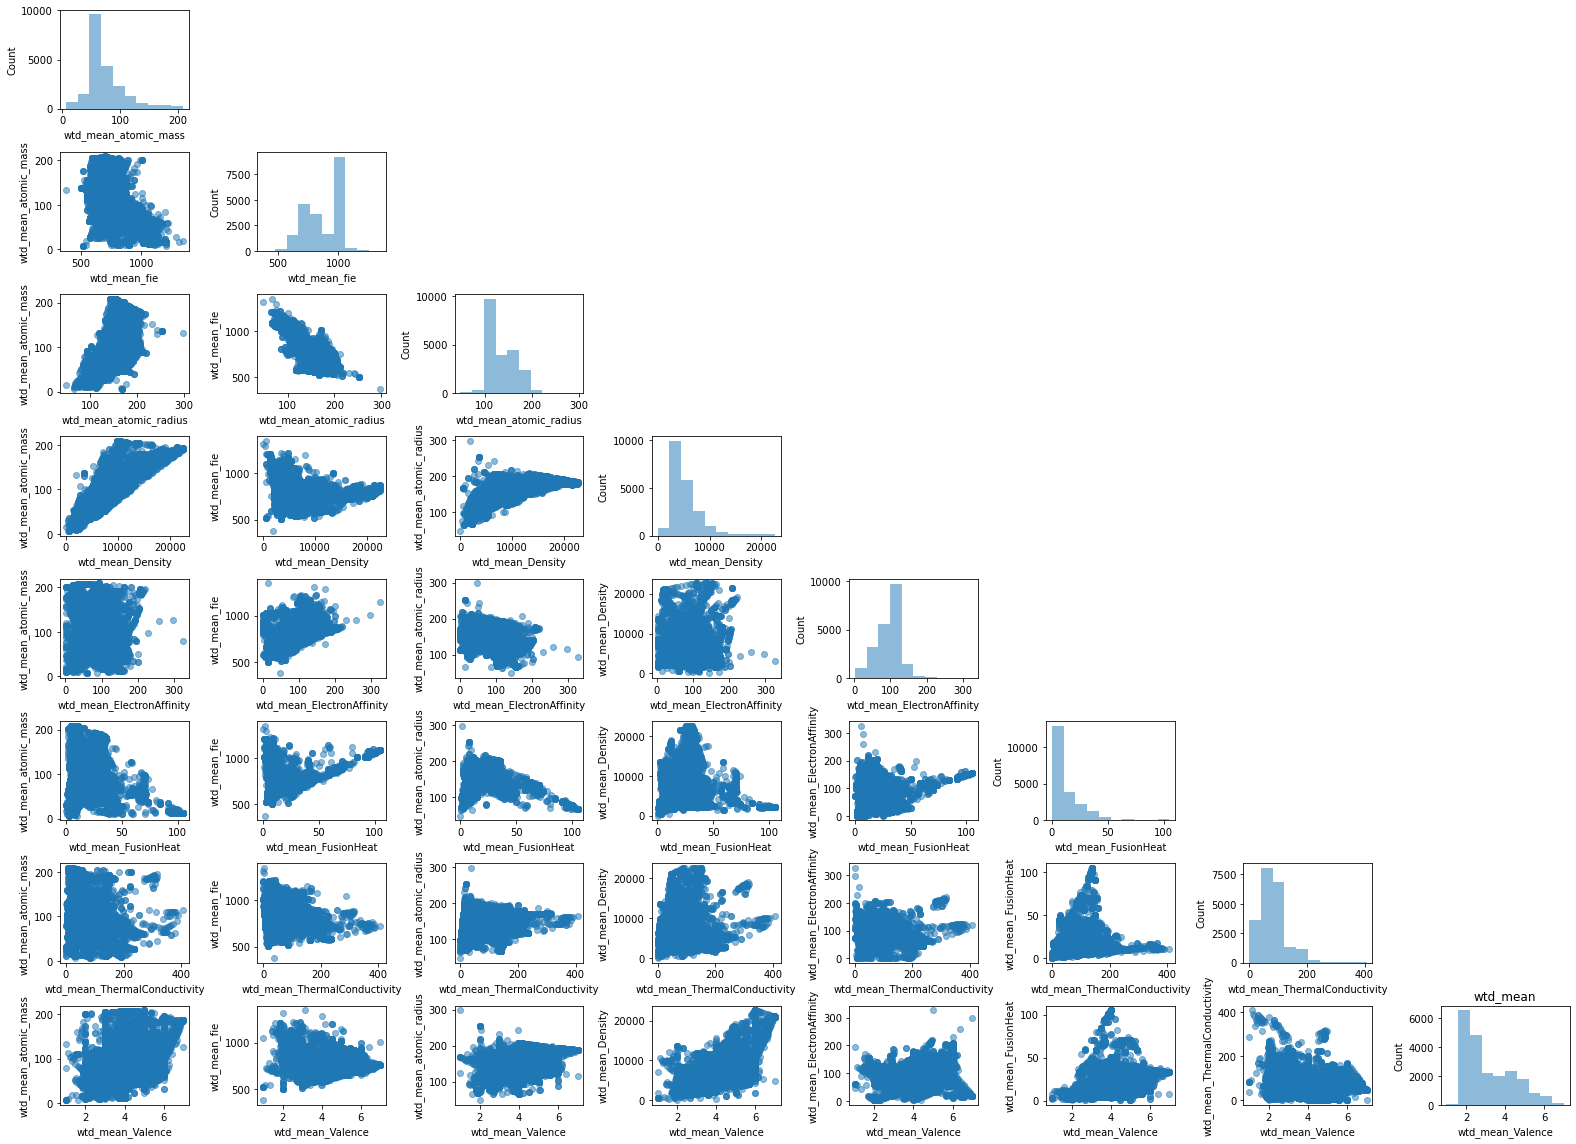

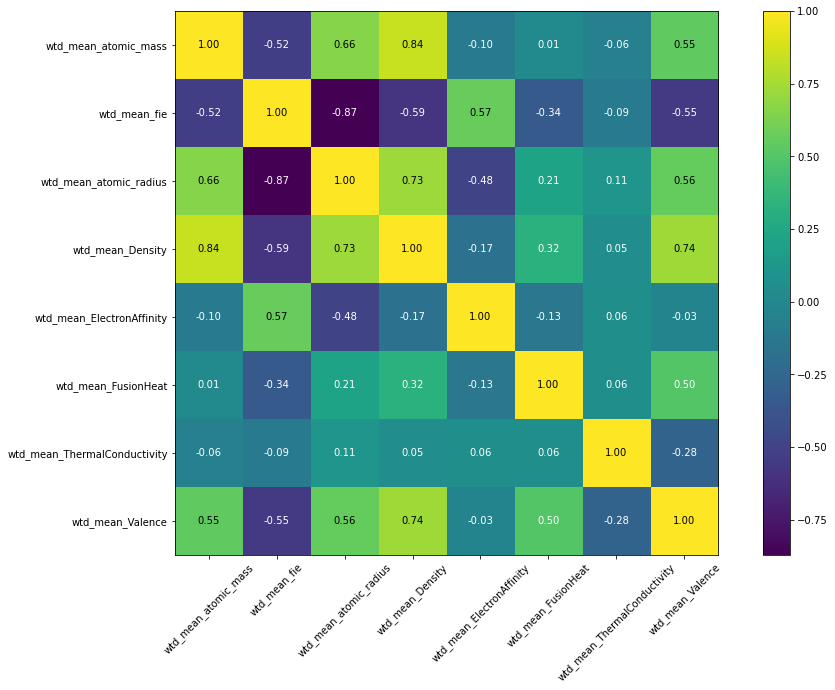

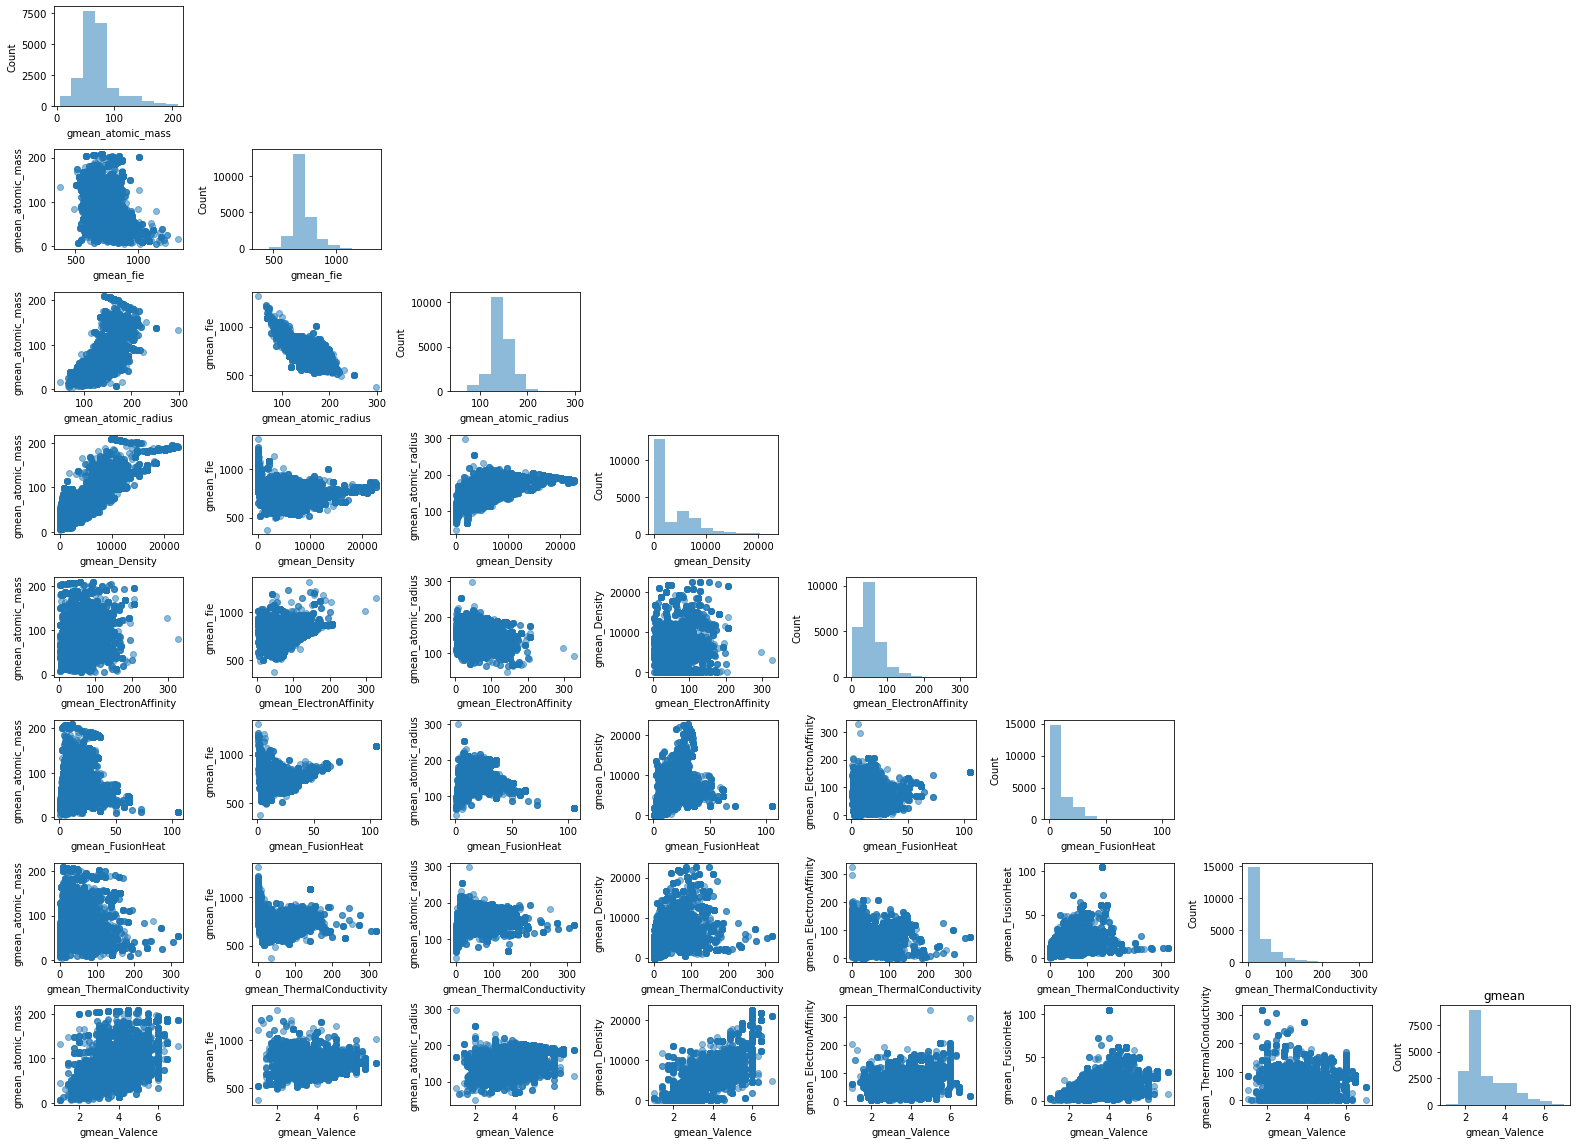

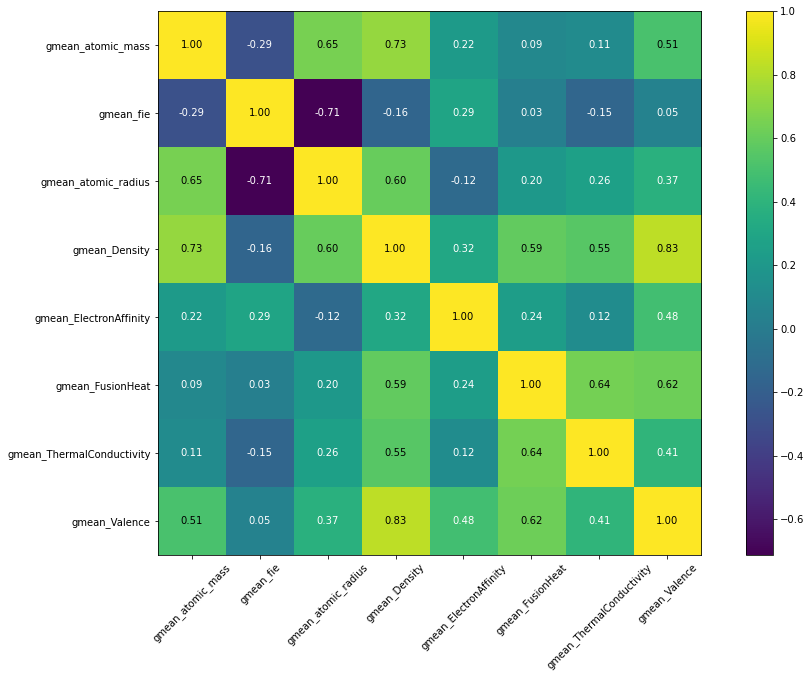

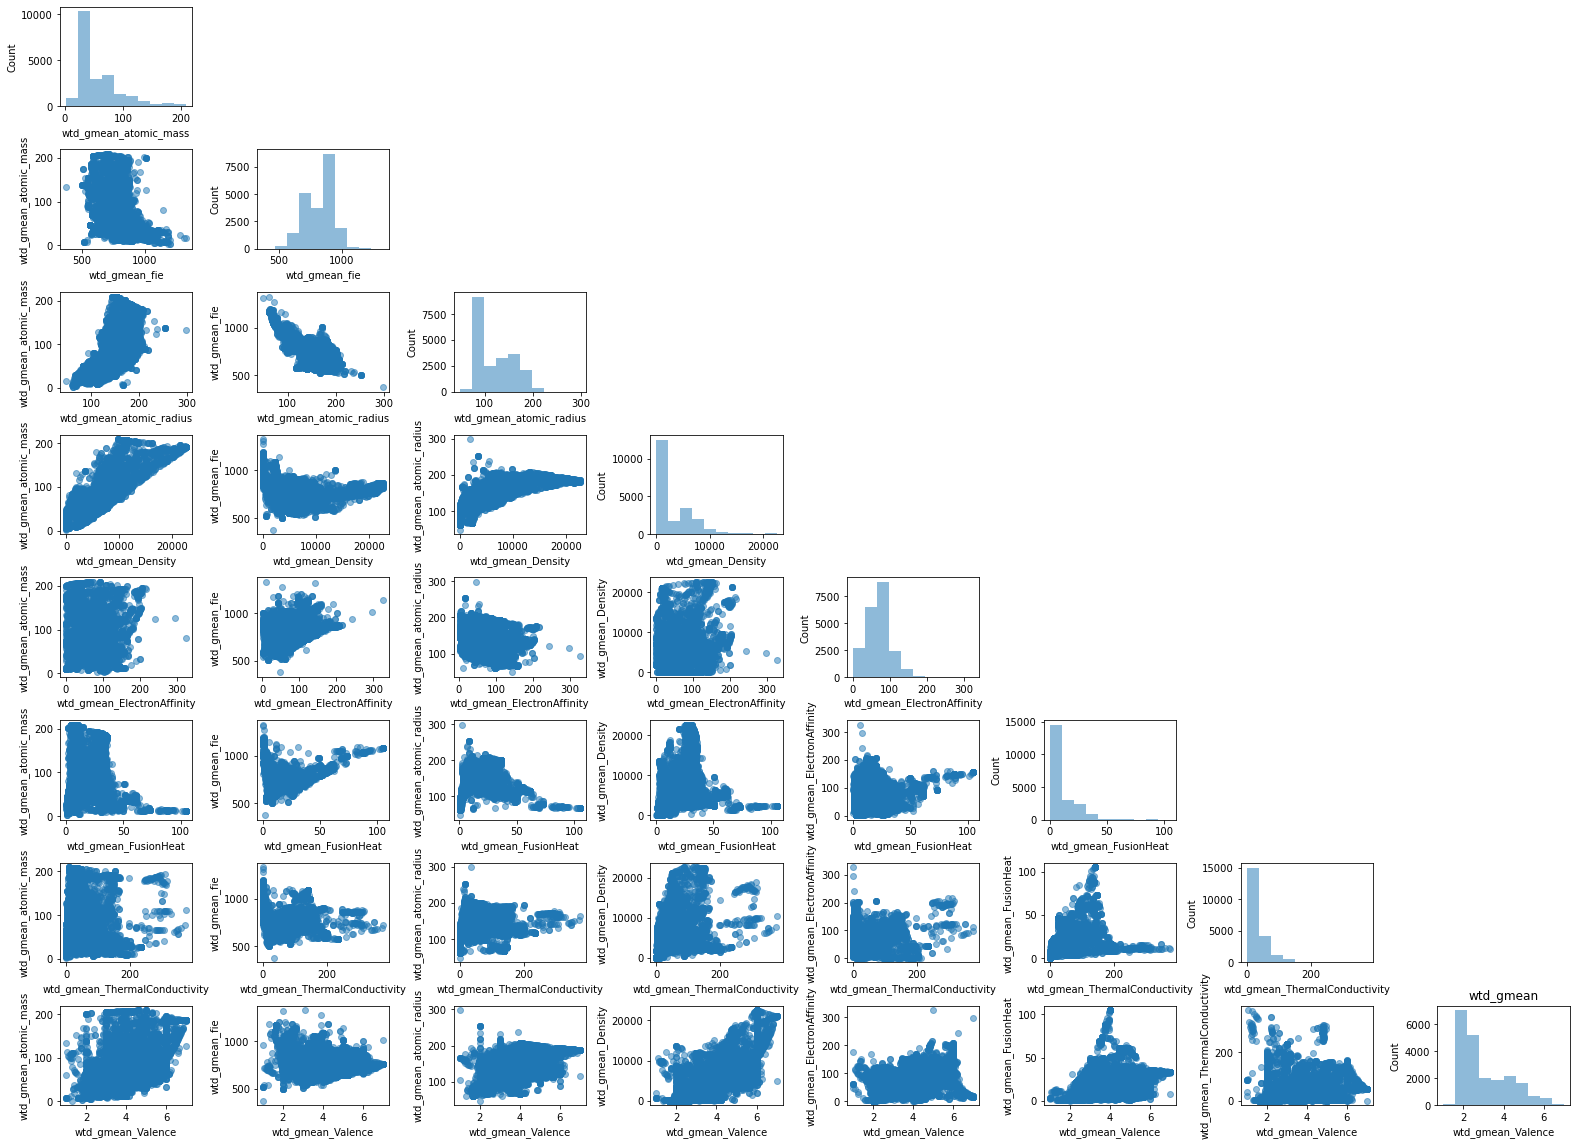

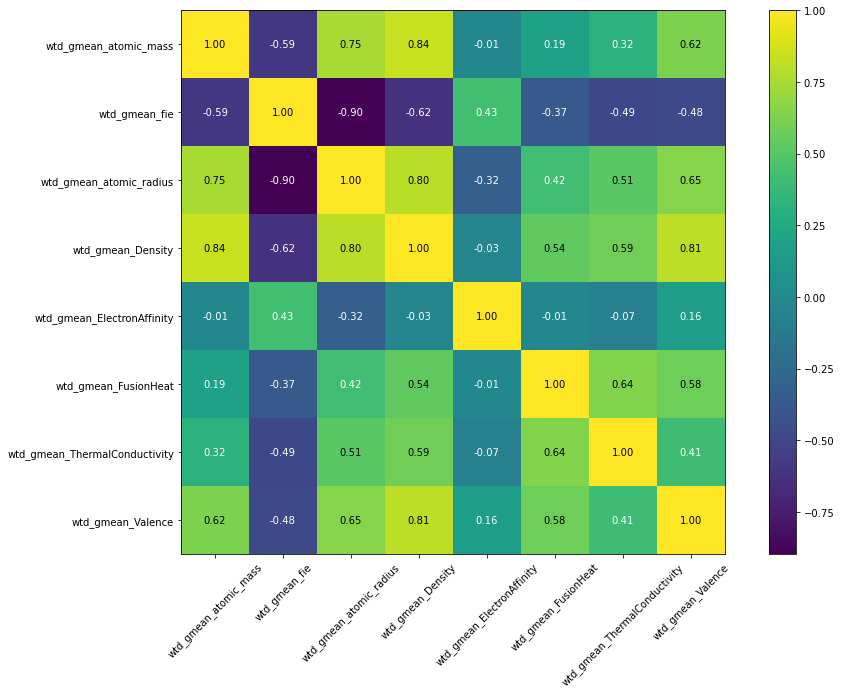

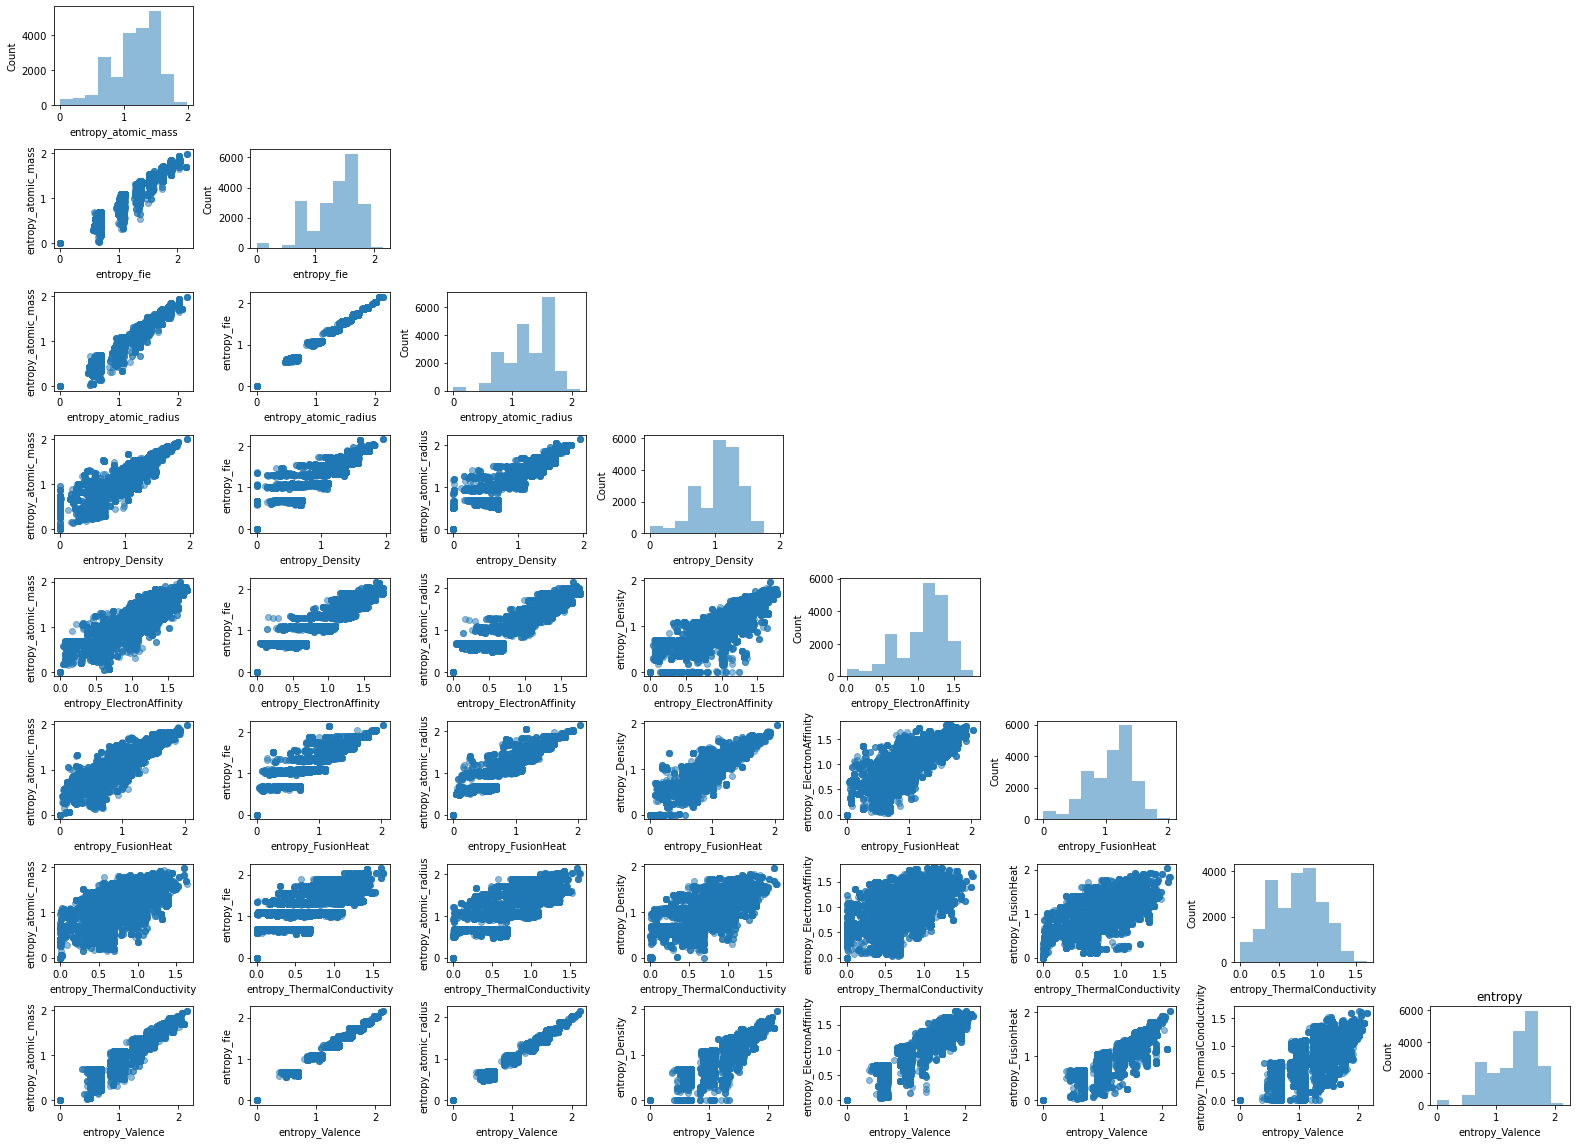

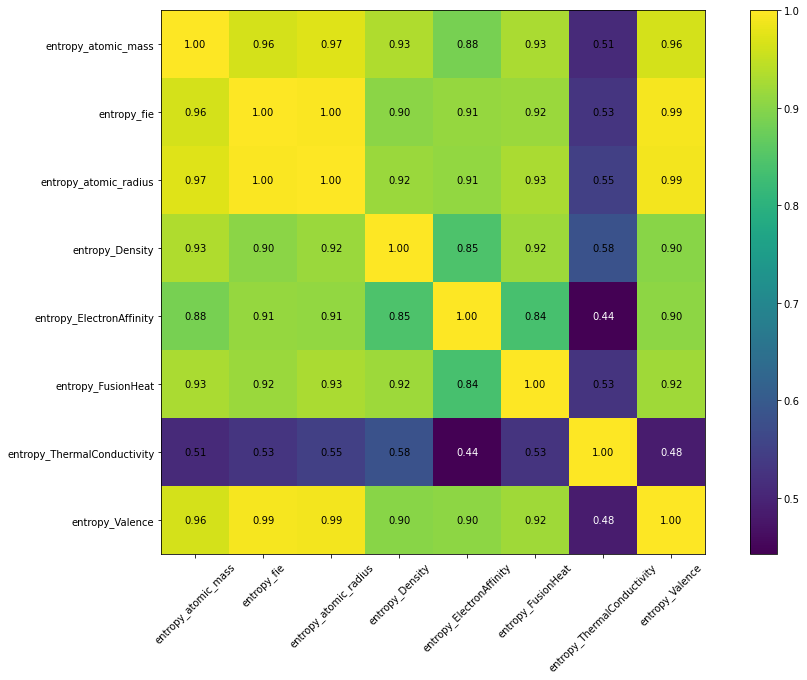

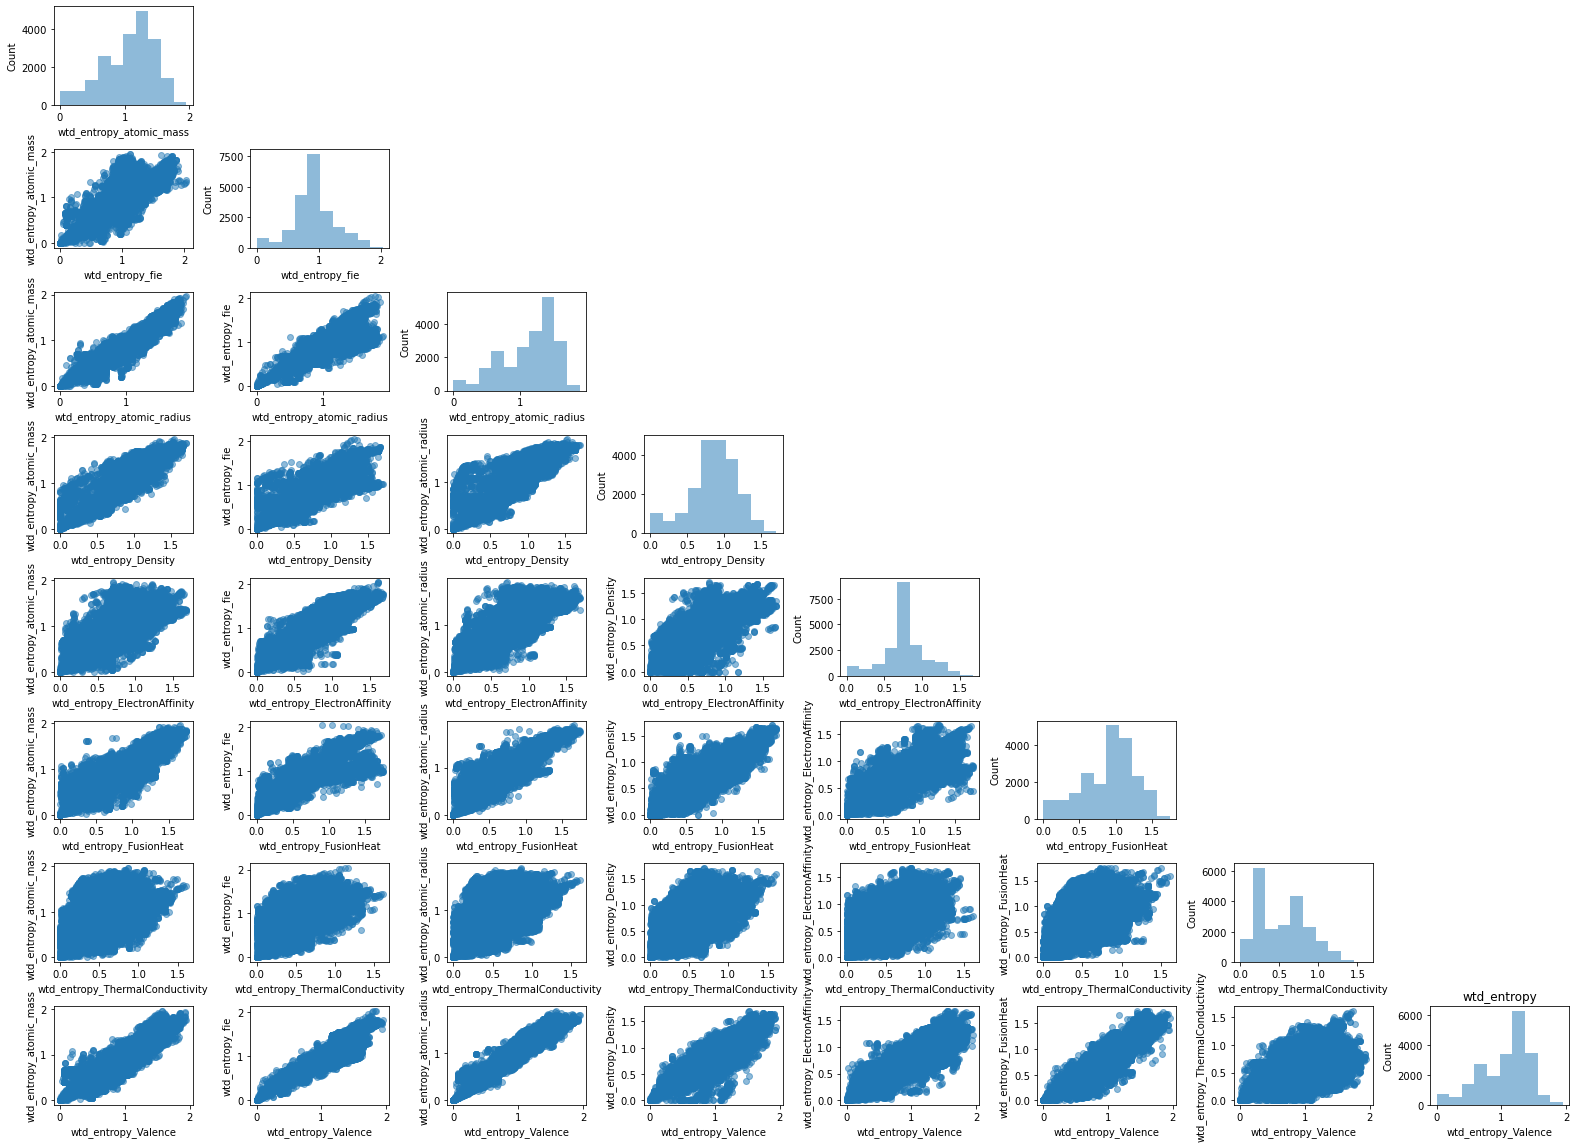

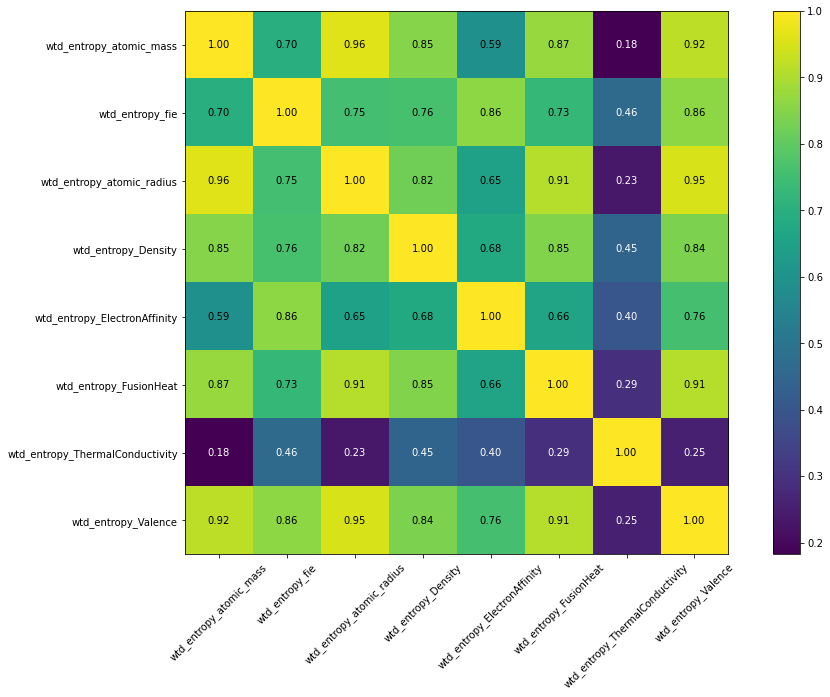

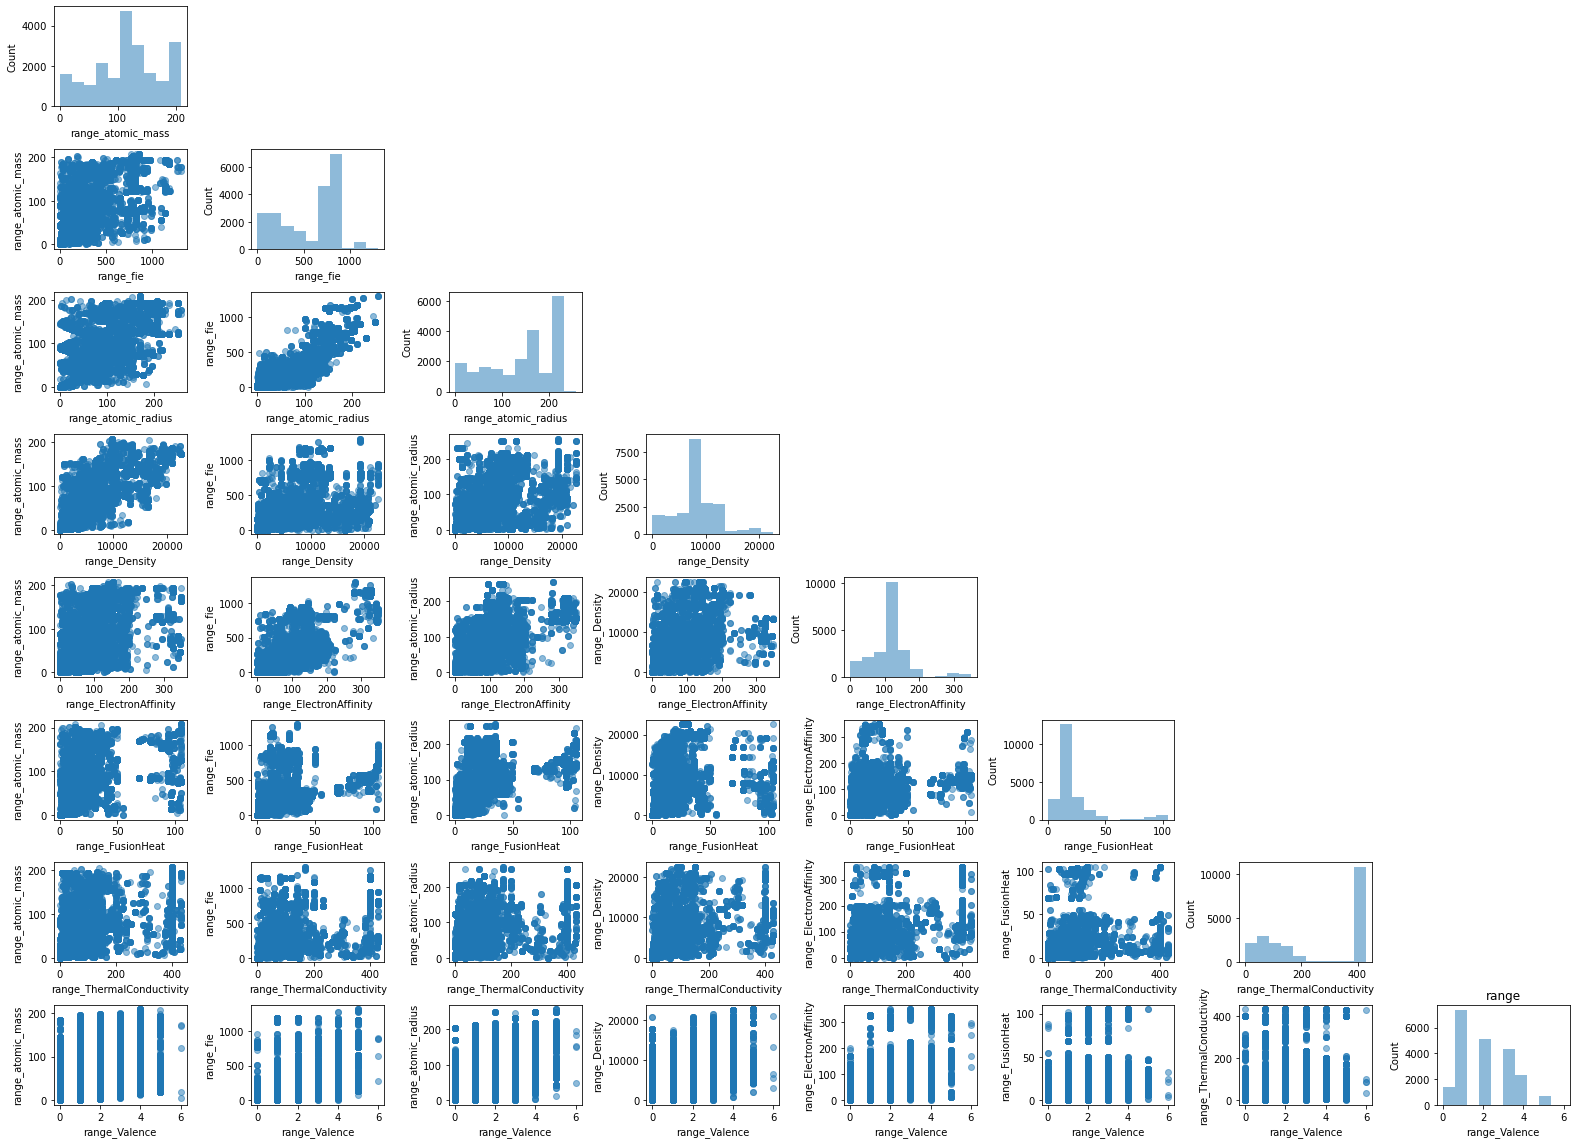

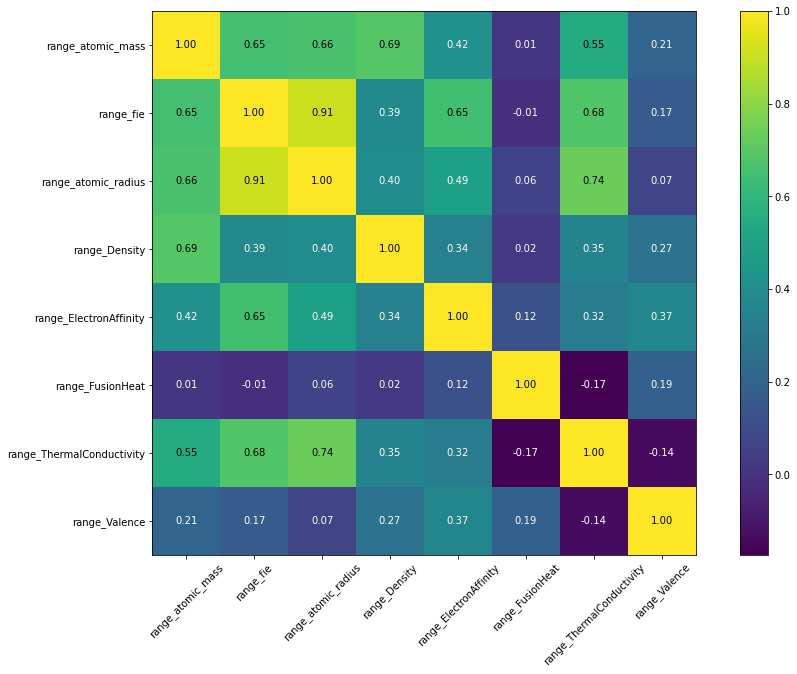

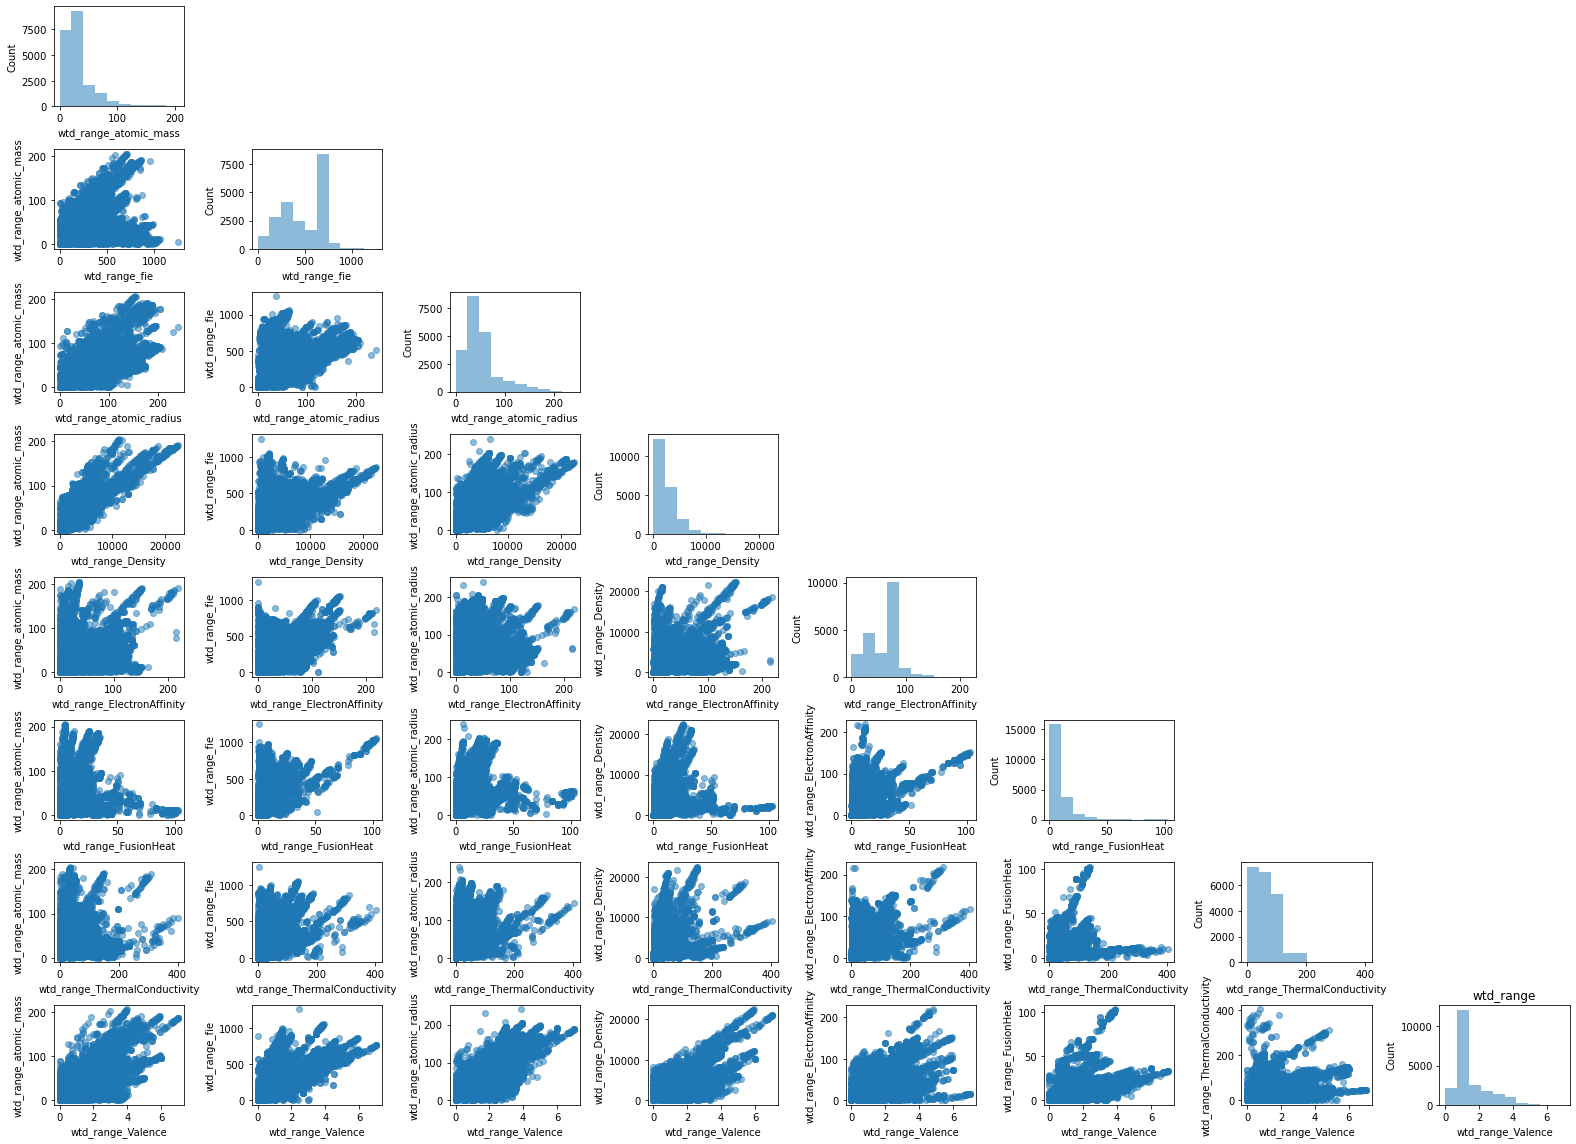

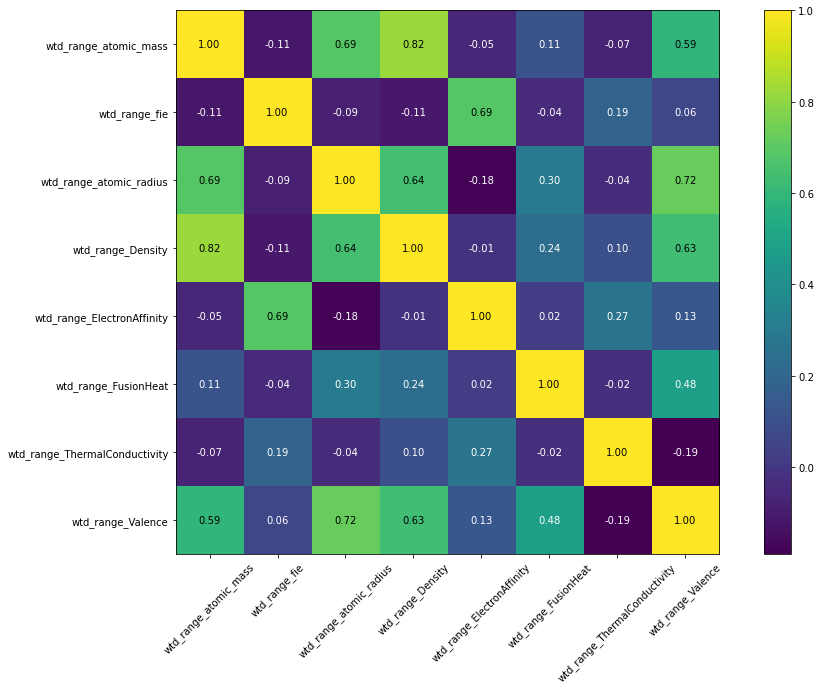

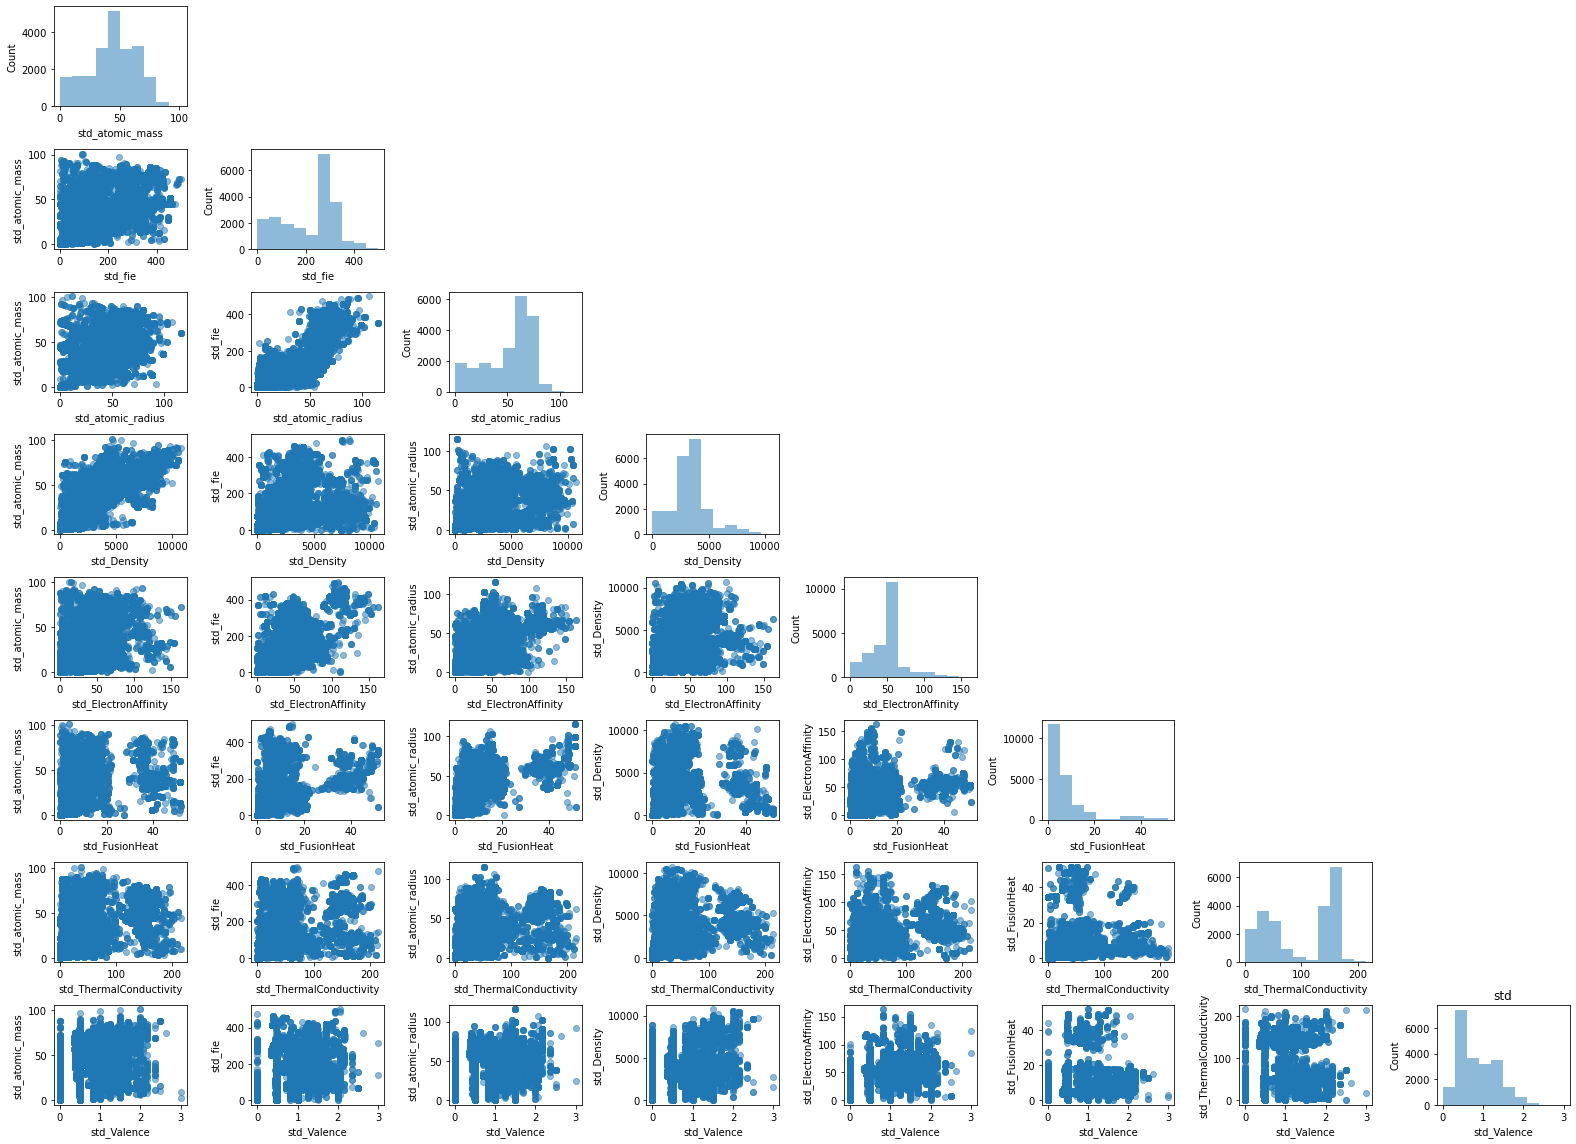

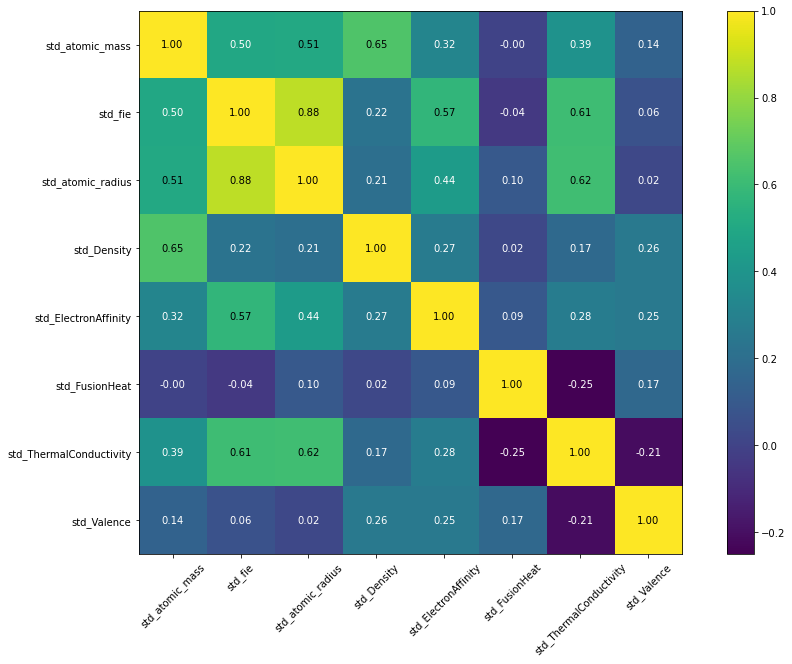

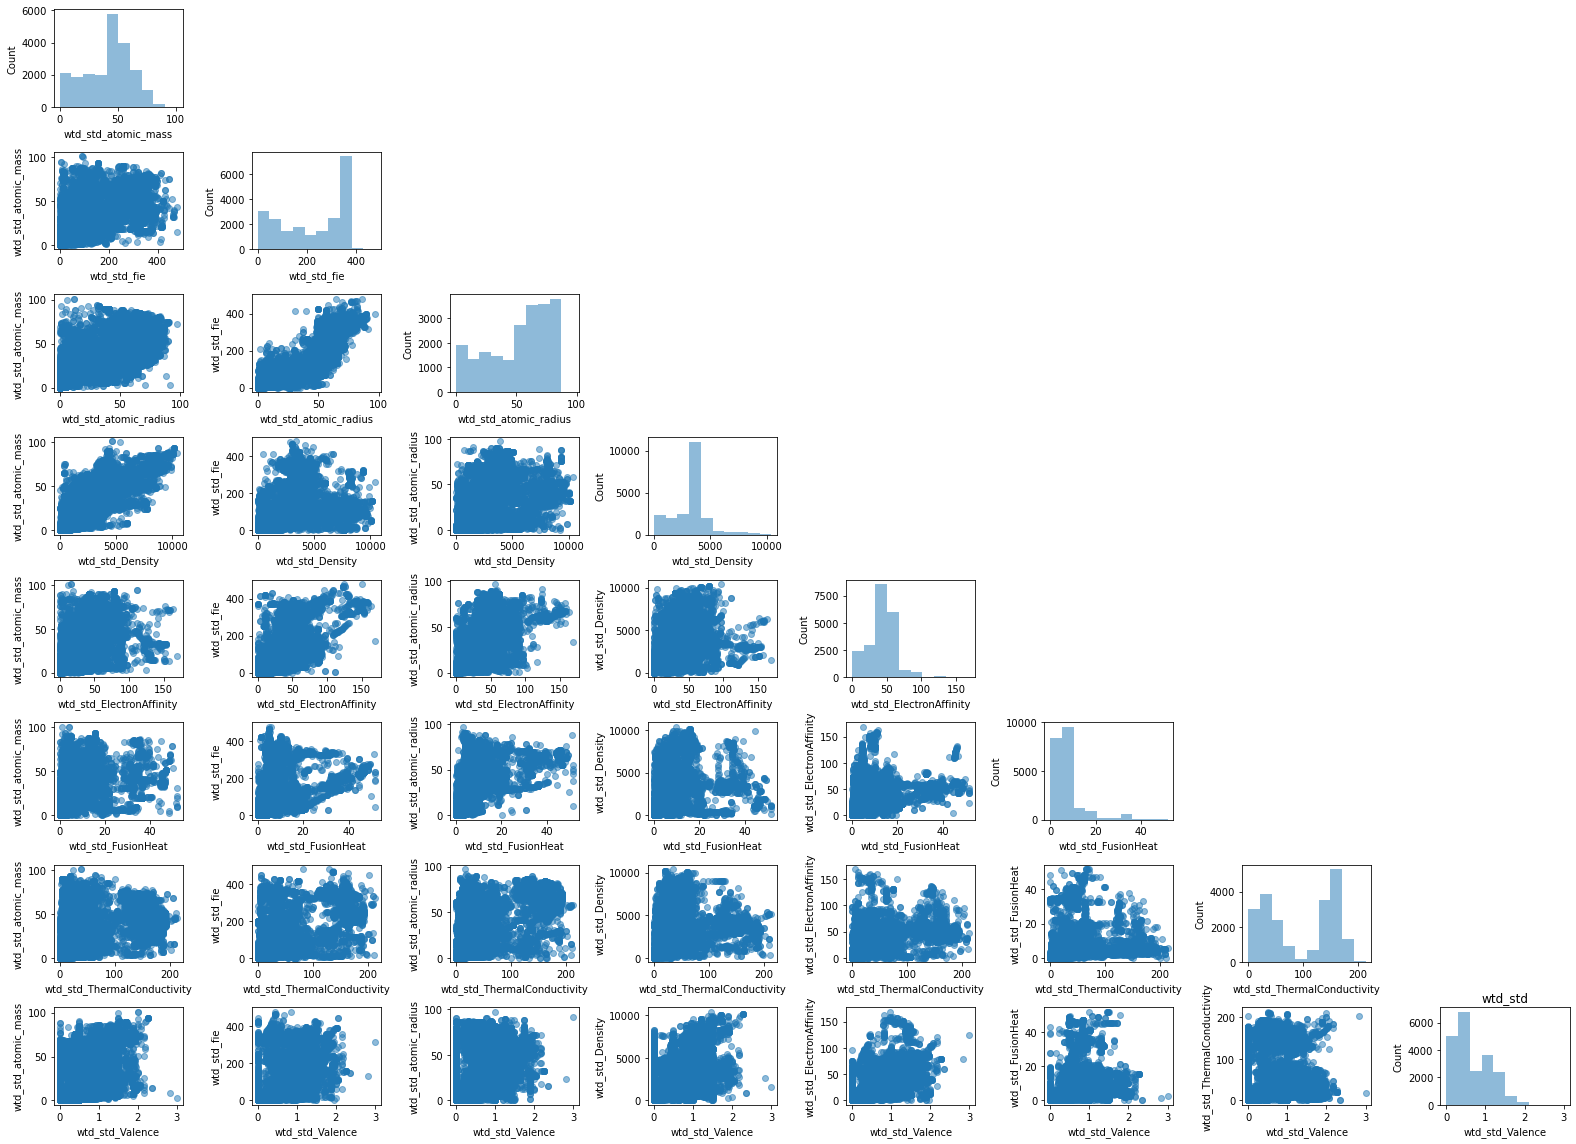

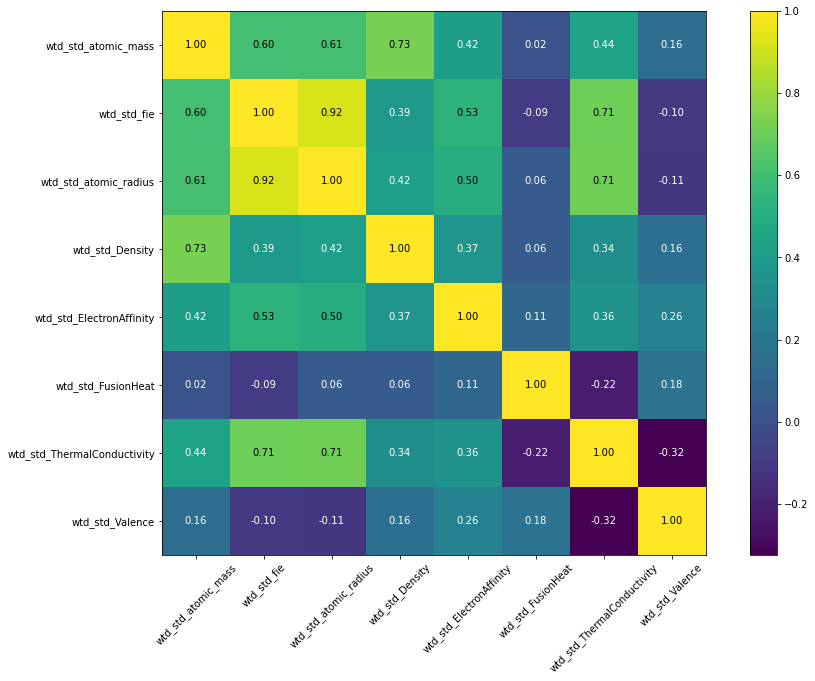

In [6]:
names = []
for i in range(10):
    nomi = []
    for j in range(8):
        nomi.append(stat_name[i]+'_'+feature_name[j])       
    names.append(nomi)
    del nomi
feature = []
for i in range(n_stat_feature):
    feature.append(df[names[i]])
    scatterplotmatrix(feature[i].values, figsize=(22, 16), 
                      names=names[i] , alpha=0.5)
    plt.tight_layout()
    plt.title(stat_name[i])
    
    #plt.savefig('SPM_'+stat_name[i]+'.png', dpi=300)
    plt.show()
    #HEAT MAP
    cm = np.corrcoef(feature[i].values.T)
    hm = heatmap(cm, row_names=names[i], column_names=names[i], figsize=(16, 10))
    #plt.savefig('HM_'+stat_name[i]+'.png', dpi=300)
    plt.show()

## Preprocessing

### Feature Selection

Variance Feature Selection 

In [4]:
df_vt=df.drop(['critical_temp'], axis=1)
var_thr = VarianceThreshold(threshold=10) #Removing both constant and quasi-constant
var_thr.fit(df_vt)
concol = [column for column in df_vt.columns if column not in df_vt.columns[var_thr.get_support()]]
df_vt=df_vt.drop(concol,axis=1)
print('Dimension of reduced dataset through variance tsh:', df_vt.shape)

Dimension of reduced dataset through variance tsh: (21263, 56)


SBS

In [5]:
class SBS():
    def __init__(self, estimator, k_features, scoring=r2_score, test_size=0.20, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

#### Holdout. Creating data for traininig, validation and testing

In [6]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Standardization
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std,
                                                                    test_size=0.20, random_state=1)
# Selected with Variance Threshold
X_v, y_v = df_vt.iloc[:, :-1].values, df.iloc[:, -1:].values
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, test_size=0.20, random_state=1)
# Standardization
sc_xv = StandardScaler()
sc_yv = StandardScaler()
X_std_v = sc_xv.fit_transform(X_v)
y_std_v = sc_yv.fit_transform(y_v)
X_train_std_v, X_test_std_v, y_train_std_v, y_test_std_v = train_test_split(X_std_v, y_std_v, 
                                                                            test_size=0.20, random_state=1)


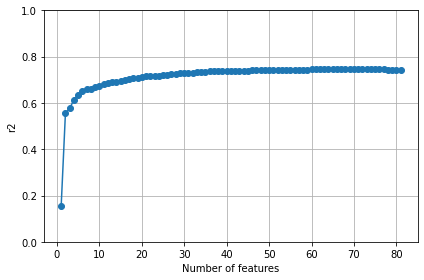

In [12]:
linr = LinearRegression()
# selecting features
sbs = SBS(linr, k_features=1)
sbs.fit(X_train_std, y_train_std)
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0, 1. ])
plt.ylabel('r2')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.savefig('sbs', dpi=300)
plt.show()
# Number of features we want to drop
n_del = 51
k3 = list(sbs.subsets_[n_del])

In [13]:
# Selected with SBS
X_sbs = X[:, k3]
X_train_sbs, X_test_sbs = X_train[:, k3], X_test[:, k3]
X_train_sbs_std, X_test_sbs_std = X_train_std[:, k3], X_test_std[:, k3]

In [13]:
print(f'All features: {len(X[0])}, after Variance selection: {len(X_v[0])}, after SBS: {len(X_sbs[0])}')

All features: 81, after Variance selection: 55, after SBS: 30


## Feature Extraction

PCA

In [14]:
n_pc = 30
pca = PCA(n_components=n_pc)
X_pca = pca.fit_transform(X_std)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_std, y_std, 
                                                                    test_size=0.20, random_state=1)

Explained variance ratio with 30 components: 0.9892703612719276


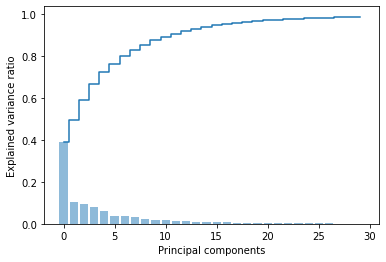

In [15]:
print(f'Explained variance ratio with {n_pc} components:', pca.explained_variance_ratio_[0:n_pc].sum())

plt.bar(range(0, n_pc), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(0, n_pc), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.savefig('pca', dpi=300)
plt.show()

## Supervised Learning for  multivariate Regression

Tool

In [16]:
def result(model, x_train, x_test, y_train, y_test):
    MODEL = clone(model)
    t_0 = time()
    MODEL.fit(x_train, y_train)
    RT= time()-t_0
    y_train_pred = MODEL.predict(x_train)
    y_test_pred = MODEL.predict(x_test)
    # K-FOLD CV
    kfold = KFold(n_splits=5).split(x_train, y_train)
    scores_train, scores = [], []
    for k,(train, test) in enumerate(kfold):
        model.fit(x_train[train], y_train[train])
        score_train = model.score(x_train[train], y_train[train])
        score = model.score(x_train[test], y_train[test])
        scores_train.append(score_train)
        scores.append(score)
    train_score = np.mean(scores_train)
    test_score = np.mean(scores)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))
    return [train_score, test_score, mse_train, mse_test, rmse_train, rmse_test, RT]


#### Multiple Linear Regression

In [17]:
lin = result(LinearRegression(), X_train, X_test, y_train, y_test)

print('ALL','\nTRAIN R2:', lin[0], 'TEST R2:', lin[1],'\nTRAIN MSE:', lin[2], 
      'TEST MSE:', lin[3], '\nTRAIN RMSE:', lin[4], 'TEST RMSE:', lin[5], 
      '\nRunning Time:', lin[6])

lin_v = result(LinearRegression(), X_train_v, X_test_v, y_train_v, y_test_v)
print('VARIANCE','\nTRAIN R2:', lin_v[0], 'TEST R2:', lin_v[1],'\nTRAIN MSE:', lin_v[2], 
      'TEST MSE:', lin_v[3], '\nTRAIN RMSE:', lin_v[4], 'TEST RMSE:', lin_v[5], 
      '\nRunning Time:', lin_v[6])
lin_sbs = result(LinearRegression(), X_train_sbs, X_test_sbs, y_train, y_test)
print('SBS','\nTRAIN R2:', lin_sbs[0], 'TEST R2:', lin_sbs[1],'\nTRAIN MSE:', lin_sbs[2], 
      'TEST MSE:', lin_sbs[3], '\nTRAIN RMSE:', lin_sbs[4], 'TEST RMSE:', lin_sbs[5], 
      '\nRunning Time:', lin_sbs[6])
lin_pca = result(LinearRegression(), X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print('PCA','\nTRAIN R2:', lin_pca[0], 'TEST R2:', lin_pca[1],'\nTRAIN MSE:', lin_pca[2], 
      'TEST MSE:', lin_pca[3], '\nTRAIN RMSE:', lin_pca[4], 'TEST RMSE:', lin_pca[5], 
      '\nRunning Time:', lin_pca[6])

ALL 
TRAIN R2: 0.7400141033173129 TEST R2: 0.7370948906648784 
TRAIN MSE: 306.07590477137427 TEST MSE: 318.27775059072144 
TRAIN RMSE: 17.49502514349077 TEST RMSE: 17.84034054021171 
Running Time: 0.0781869888305664
VARIANCE 
TRAIN R2: 0.7206152231273666 TEST R2: 0.7181295677830132 
TRAIN MSE: 328.83965190405064 TEST MSE: 336.78759251579504 
TRAIN RMSE: 18.13393647016694 TEST RMSE: 18.351773552324445 
Running Time: 0.046877384185791016
SBS 
TRAIN R2: 0.7200899882083434 TEST R2: 0.7184898721555399 
TRAIN MSE: 329.3512222160473 TEST MSE: 335.6507100402554 
TRAIN RMSE: 18.148036318457358 TEST RMSE: 18.320772637644282 
Running Time: 0.015630483627319336
PCA 
TRAIN R2: 0.7400141033173129 TEST R2: 0.7370948906648787 
TRAIN MSE: 0.26086618675209317 TEST MSE: 0.2712657279789667 
TRAIN RMSE: 0.5107506111127946 TEST RMSE: 0.520831765524115 
Running Time: 0.09852147102355957


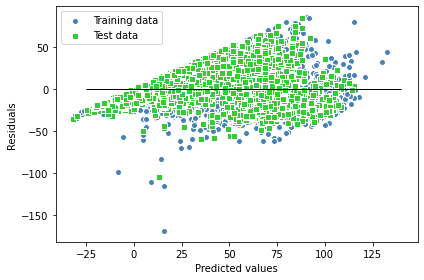

In [18]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

plt.scatter(y_train_pred,  y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-25,xmax=140, color='black', lw=1)
plt.tight_layout()
plt.savefig('residualplot', dpi=300)
plt.show()

### Linear Regression with Regolarisation

#### Lasso

In [19]:
lasso = result(Lasso(alpha=0.05), X_train_std, X_test_std, y_train_std, y_test_std)

print('ALL','\nTRAIN R2:', lasso[0], 'TEST R2:', lasso[1],'\nTRAIN MSE:', lasso[2], 
      'TEST MSE:', lasso[3], '\nTRAIN RMSE:', lasso[4], 'TEST RMSE:', lasso[5], 
      '\nRunning Time:', lasso[6])

lasso_v = result(Lasso(alpha=0.05), X_train_std_v, X_test_std_v, y_train_std_v, y_test_std_v)
print('VARIANCE','\nTRAIN R2:', lasso_v[0], 'TEST R2:', lasso_v[1],'\nTRAIN MSE:', lasso_v[2], 
      'TEST MSE:', lasso_v[3], '\nTRAIN RMSE:', lasso_v[4], 'TEST RMSE:', lasso_v[5], 
      '\nRunning Time:', lasso_v[6])
lasso_sbs = result(Lasso(alpha=0.05), X_train_sbs_std, X_test_sbs_std, y_train_std, y_test_std)
print('SBS','\nTRAIN R2:', lasso_sbs[0], 'TEST R2:', lasso_sbs[1],'\nTRAIN MSE:', lasso_sbs[2], 
      'TEST MSE:', lasso_sbs[3], '\nTRAIN RMSE:', lasso_sbs[4], 'TEST RMSE:', lasso_sbs[5], 
      '\nRunning Time:', lasso_sbs[6])
lasso_pca = result(Lasso(alpha=0.05), X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print('PCA','\nTRAIN R2:', lasso_pca[0], 'TEST R2:', lasso_pca[1],'\nTRAIN MSE:', lasso_pca[2], 
      'TEST MSE:', lasso_pca[3], '\nTRAIN RMSE:', lasso_pca[4], 'TEST RMSE:', lasso_pca[5], 
      '\nRunning Time:', lasso_pca[6])

ALL 
TRAIN R2: 0.6230677669776361 TEST R2: 0.6223773011002608 
TRAIN MSE: 0.3778995565336236 TEST MSE: 0.37455635344380384 
TRAIN RMSE: 0.6147353548752695 TEST RMSE: 0.6120100925996268 
Running Time: 0.6423318386077881
VARIANCE 
TRAIN R2: 0.6109938467544097 TEST R2: 0.6102741018500006 
TRAIN MSE: 0.38998164125596685 TEST MSE: 0.3876077903462471 
TRAIN RMSE: 0.6244851009079134 TEST RMSE: 0.6225815531689379 
Running Time: 0.4642496109008789
SBS 
TRAIN R2: 0.6262473225331047 TEST R2: 0.6256150604117373 
TRAIN MSE: 0.3746848845370453 TEST MSE: 0.37276543289069763 
TRAIN RMSE: 0.6121150909241213 TEST RMSE: 0.6105451931599312 
Running Time: 0.27780985832214355
PCA 
TRAIN R2: 0.6230677669776361 TEST R2: 0.6223773011002608 
TRAIN MSE: 0.3778995565336236 TEST MSE: 0.37455635344380384 
TRAIN RMSE: 0.6147353548752695 TEST RMSE: 0.6120100925996268 
Running Time: 0.7287507057189941


C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e+03, tolerance: 1.372e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.440e+01, tolerance: 1.372e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

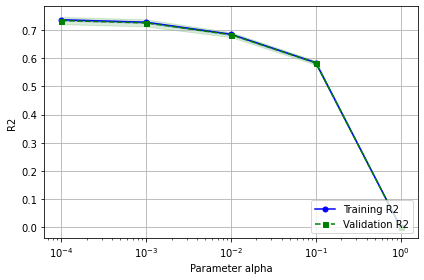

In [20]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0]
train_scores, test_scores = validation_curve(estimator=Lasso(), X=X_train_std, y=y_train_std,
                                             param_name='alpha', param_range=param_range,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter alpha')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_lasso.png', dpi=300)
plt.show()

#### Ridge

In [21]:
ridge = result(Ridge(), X_train_std, X_test_std, y_train_std, y_test_std)
print('ALL','\nTRAIN R2:', ridge[0], 'TEST R2:', ridge[1],'\nTRAIN MSE:', ridge[2], 
      'TEST MSE:', ridge[3], '\nTRAIN RMSE:', ridge[4], 'TEST RMSE:', ridge[5], 
      '\nRunning Time:', ridge[6])

ridge_v = result(Ridge(), X_train_std_v, X_test_std_v, y_train_std_v, y_test_std_v)
print('VARIANCE','\nTRAIN R2:', ridge_v[0], 'TEST R2:', ridge_v[1],'\nTRAIN MSE:', ridge_v[2], 
      'TEST MSE:', ridge_v[3], '\nTRAIN RMSE:', ridge_v[4], 'TEST RMSE:', ridge_v[5], 
      '\nRunning Time:', ridge_v[6])
ridge_sbs = result(Ridge(), X_train_sbs_std, X_test_sbs_std, y_train_std, y_test_std)
print('SBS','\nTRAIN R2:', ridge_sbs[0], 'TEST R2:', ridge_sbs[1],'\nTRAIN MSE:', ridge_sbs[2], 
      'TEST MSE:', ridge_sbs[3], '\nTRAIN RMSE:', ridge_sbs[4], 'TEST RMSE:', ridge_sbs[5], 
      '\nRunning Time:', ridge_sbs[6])
ridge_pca = result(Ridge(), X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print('PCA','\nTRAIN R2:', ridge_pca[0], 'TEST R2:', ridge_pca[1],'\nTRAIN MSE:', ridge_pca[2], 
      'TEST MSE:', ridge_pca[3], '\nTRAIN RMSE:', ridge_pca[4], 'TEST RMSE:', ridge_pca[5], 
      '\nRunning Time:', ridge_pca[6])

ALL 
TRAIN R2: 0.7394951295058352 TEST R2: 0.7366867326175478 
TRAIN MSE: 0.2612707538991939 TEST MSE: 0.2707939357792362 
TRAIN RMSE: 0.5111465092311537 TEST RMSE: 0.5203786465442604 
Running Time: 0.015650510787963867
VARIANCE 
TRAIN R2: 0.7205054561102495 TEST R2: 0.7181239697513696 
TRAIN MSE: 0.28034455977675915 TEST MSE: 0.2867929097224854 
TRAIN RMSE: 0.5294757404988062 TEST RMSE: 0.5355304937372711 
Running Time: 0.01567983627319336
SBS 
TRAIN R2: 0.7200638153519144 TEST R2: 0.7184738352802971 
TRAIN MSE: 0.2807205804283522 TEST MSE: 0.28600011148097604 
TRAIN RMSE: 0.5298307092160214 TEST RMSE: 0.5347897825136303 
Running Time: 0.027383089065551758
PCA 
TRAIN R2: 0.7394951295058352 TEST R2: 0.7366867326175478 
TRAIN MSE: 0.2612707538991939 TEST MSE: 0.2707939357792362 
TRAIN RMSE: 0.5111465092311537 TEST RMSE: 0.5203786465442604 
Running Time: 0.01563549041748047


Validation Curve

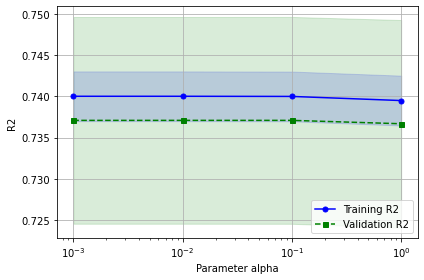

In [22]:
param_range = [0.001, 0.01, 0.1, 1.0]
train_scores, test_scores = validation_curve(estimator=Ridge(), X=X_train_std, y=y_train_std,
                                             param_name='alpha', param_range=param_range,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter alpha')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_ridge.png', dpi=300)
plt.show()

#### ElasticNet

In [23]:
elanet = result(ElasticNet(alpha=1.0, l1_ratio=0.01), X_train_std, X_test_std, y_train_std, y_test_std)
print('ALL','\nTRAIN R2:', elanet[0], 'TEST R2:', elanet[1],'\nTRAIN MSE:', elanet[2], 
      'TEST MSE:', elanet[3], '\nTRAIN RMSE:', elanet[4], 'TEST RMSE:', elanet[5], 
      '\nRunning Time:', elanet[6])

elanet_v = result(ElasticNet(alpha=1.0, l1_ratio=0.01), X_train_std_v, X_test_std_v, 
                  y_train_std_v, y_test_std_v)
print('VARIANCE','\nTRAIN R2:', elanet_v[0], 'TEST R2:', elanet_v[1],'\nTRAIN MSE:', elanet_v[2], 
      'TEST MSE:', elanet_v[3], '\nTRAIN RMSE:', elanet_v[4], 'TEST RMSE:', elanet_v[5], 
      '\nRunning Time:', elanet_v[6])
elanet_sbs = result(ElasticNet(alpha=1.0, l1_ratio=0.01), X_train_sbs_std, X_test_sbs_std,
                    y_train_std, y_test_std)
print('SBS','\nTRAIN R2:', elanet_sbs[0], 'TEST R2:', elanet_sbs[1],'\nTRAIN MSE:', elanet_sbs[2], 
      'TEST MSE:', elanet_sbs[3], '\nTRAIN RMSE:', elanet_sbs[4], 'TEST RMSE:', elanet_sbs[5], 
      '\nRunning Time:', elanet_sbs[6])
elanet_pca = result(ElasticNet(alpha=1.0, l1_ratio=0.01), X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print('PCA','\nTRAIN R2:', elanet_pca[0], 'TEST R2:', elanet_pca[1],'\nTRAIN MSE:', elanet_pca[2], 
      'TEST MSE:', elanet_pca[3], '\nTRAIN RMSE:', elanet_pca[4], 'TEST RMSE:', elanet_pca[5], 
      '\nRunning Time:', elanet_pca[6])

ALL 
TRAIN R2: 0.6113038176922275 TEST R2: 0.6104923902274131 
TRAIN MSE: 0.38970819770774856 TEST MSE: 0.38656868896079943 
TRAIN RMSE: 0.6242661273108998 TEST RMSE: 0.6217464828696656 
Running Time: 2.26115083694458
VARIANCE 
TRAIN R2: 0.5779424025936883 TEST R2: 0.5771544594872887 
TRAIN MSE: 0.42319338764382597 TEST MSE: 0.4192454774127449 
TRAIN RMSE: 0.6505331564523257 TEST RMSE: 0.6474916813463667 
Running Time: 0.9208283424377441
SBS 
TRAIN R2: 0.589510359576354 TEST R2: 0.5889191141419496 
TRAIN MSE: 0.4115317630289535 TEST MSE: 0.4072731257397717 
TRAIN RMSE: 0.6415074146328735 TEST RMSE: 0.638179540364443 
Running Time: 0.2895362377166748
PCA 
TRAIN R2: 0.6113038176922275 TEST R2: 0.6104923902274131 
TRAIN MSE: 0.38970819770774856 TEST MSE: 0.38656868896079943 
TRAIN RMSE: 0.6242661273108998 TEST RMSE: 0.6217464828696656 
Running Time: 2.322425603866577


In [24]:
param_grid = [{'l1_ratio': [0.001,0.01,0.1], 'alpha': [0.001,0.01,0.1,1]}]
paki = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, scoring='r2', refit=True, n_jobs=-1)
gs = paki.fit(X_train_std, y_train_std)
print(gs.best_score_)
print(gs.best_params_)

0.7335824600271762
{'alpha': 0.001, 'l1_ratio': 0.001}


C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+03, tolerance: 1.705e+00
  model = cd_fast.enet_coordinate_descent(


### RANSAC

In [25]:
ransac = RANSACRegressor(LinearRegression(), max_trials=10, min_samples=1000, loss='squared_error',
                         residual_threshold=100.0, random_state=0)

ran = result(ransac, X_train, X_test, y_train, y_test)
print('ALL','\nTRAIN R2:', ran[0], 'TEST R2:', ran[1],'\nTRAIN MSE:', ran[2], 
      'TEST MSE:', ran[3], '\nTRAIN RMSE:', ran[4], 'TEST RMSE:', ran[5], 
      '\nRunning Time:', ran[6])

ran_v = result(ransac, X_train_v, X_test_v, y_train_v, y_test_v)
print('VARIANCE','\nTRAIN R2:', ran_v[0], 'TEST R2:', ran_v[1],'\nTRAIN MSE:', ran_v[2], 
      'TEST MSE:', ran_v[3], '\nTRAIN RMSE:', ran_v[4], 'TEST RMSE:', ran_v[5], 
      '\nRunning Time:', ran_v[6])
ran_sbs = result(ransac, X_train_sbs, X_test_sbs, y_train, y_test)
print('SBS','\nTRAIN R2:', ran_sbs[0], 'TEST R2:', ran_sbs[1],'\nTRAIN MSE:', ran_sbs[2], 
      'TEST MSE:', ran_sbs[3], '\nTRAIN RMSE:', ran_sbs[4], 'TEST RMSE:', ran_sbs[5], 
      '\nRunning Time:', ran_sbs[6])
ran_pca = result(ransac, X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print('PCA','\nTRAIN R2:', ran_pca[0], 'TEST R2:', ran_pca[1],'\nTRAIN MSE:', ran_pca[2], 
      'TEST MSE:', ran_pca[3], '\nTRAIN RMSE:', ran_pca[4], 'TEST RMSE:', ran_pca[5], 
      '\nRunning Time:', ran_pca[6])

ALL 
TRAIN R2: 0.7257428069623372 TEST R2: 0.7219468193057302 
TRAIN MSE: 333.1504614039085 TEST MSE: 341.8027050287343 
TRAIN RMSE: 18.252409742384934 TEST RMSE: 18.48790699426883 
Running Time: 0.40427374839782715
VARIANCE 
TRAIN R2: 0.7098293561828148 TEST R2: 0.7085172621865824 
TRAIN MSE: 352.4559955696074 TEST MSE: 359.50932174698073 
TRAIN RMSE: 18.773811428945574 TEST RMSE: 18.960731044634876 
Running Time: 0.2623445987701416
SBS 
TRAIN R2: 0.7132215653117593 TEST R2: 0.7139224371382766 
TRAIN MSE: 342.82723242673234 TEST MSE: 349.1374641066445 
TRAIN RMSE: 18.515594303903192 TEST RMSE: 18.685220472519035 
Running Time: 0.10030484199523926
PCA 
TRAIN R2: 0.7400141033173129 TEST R2: 0.7370948906648787 
TRAIN MSE: 0.26086618675209317 TEST MSE: 0.2712657279789667 
TRAIN RMSE: 0.5107506111127946 TEST RMSE: 0.520831765524115 
Running Time: 0.14113235473632812


Grid Search

In [26]:
param_range = [10.0, 100.0, 1000.0]
param_grid = [{'max_trials': param_range, 'min_samples': param_range, 'residual_threshold':param_range}]

gs = GridSearchCV(estimator=RANSACRegressor(), param_grid=param_grid, scoring='r2', refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7371947643817148
{'max_trials': 100.0, 'min_samples': 1000.0, 'residual_threshold': 100.0}


#### SVM Regressor

In [27]:
svm = result(LinearSVR(epsilon=1.5), X_train_std, X_test_std, np.ravel(y_train_std), y_test_std)
print('ALL','\nTRAIN R2:', svm[0], 'TEST R2:', svm[1],'\nTRAIN MSE:', svm[2], 
      'TEST MSE:', svm[3], '\nTRAIN RMSE:', svm[4], 'TEST RMSE:', svm[5], 
      '\nRunning Time:', svm[6])

svm_v = result(LinearSVR(epsilon=1.5), X_train_std_v, X_test_std_v, 
               np.ravel(y_train_std_v), y_test_std_v)
print('VARIANCE','\nTRAIN R2:', svm_v[0], 'TEST R2:', svm_v[1],'\nTRAIN MSE:', svm_v[2], 
      'TEST MSE:', svm_v[3], '\nTRAIN RMSE:', svm_v[4], 'TEST RMSE:', svm_v[5], 
      '\nRunning Time:', svm_v[6])
svm_sbs = result(LinearSVR(epsilon=1.5), X_train_sbs, X_test_sbs, np.ravel(y_train), y_test)
print('SBS','\nTRAIN R2:', svm_sbs[0], 'TEST R2:', svm_sbs[1],'\nTRAIN MSE:', svm_sbs[2], 
      'TEST MSE:', svm_sbs[3], '\nTRAIN RMSE:', svm_sbs[4], 'TEST RMSE:', svm_sbs[5], 
      '\nRunning Time:', svm_sbs[6])

C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Li

ALL 
TRAIN R2: 0.5515342859128948 TEST R2: 0.5499824396849063 
TRAIN MSE: 0.443844266677201 TEST MSE: 0.45188190016798 
TRAIN RMSE: 0.6662163812735327 TEST RMSE: 0.6722216153680124 
Running Time: 0.38683581352233887


C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Li

VARIANCE 
TRAIN R2: 0.5583556519669753 TEST R2: 0.5563638248616458 
TRAIN MSE: 0.4416737215087592 TEST MSE: 0.4459791435970112 
TRAIN RMSE: 0.6645853756356359 TEST RMSE: 0.6678166991001432 
Running Time: 0.4151926040649414


C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SBS 
TRAIN R2: 0.4689457683964459 TEST R2: 0.46374054110886254 
TRAIN MSE: 682.0888045626859 TEST MSE: 684.2494125825675 
TRAIN RMSE: 26.116829910283634 TEST RMSE: 26.158161490872548 
Running Time: 2.781965494155884


C:\Users\lipar\anaconda3\envs\AI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Non Linear Regression

#### Decision Tree

In [28]:
dt = result(DecisionTreeRegressor(max_depth=12, criterion='squared_error'), X_train, X_test, y_train, y_test)
print('ALL','\nTRAIN R2:', dt[0], 'TEST R2:', dt[1],'\nTRAIN MSE:', dt[2], 
      'TEST MSE:', dt[3], '\nTRAIN RMSE:', dt[4], 'TEST RMSE:', dt[5], 
      '\nRunning Time:', dt[6])

dt_v = result(DecisionTreeRegressor(max_depth=12, criterion='squared_error'), X_train_v, X_test_v, y_train_v, y_test_v)
print('VARIANCE','\nTRAIN R2:', dt_v[0], 'TEST R2:', dt_v[1],'\nTRAIN MSE:', dt_v[2], 
      'TEST MSE:', dt_v[3], '\nTRAIN RMSE:', dt_v[4], 'TEST RMSE:', dt_v[5], 
      '\nRunning Time:', dt_v[6])
dt_sbs = result(DecisionTreeRegressor(max_depth=12, criterion='squared_error'), X_train_sbs, X_test_sbs, y_train, y_test)
print('SBS','\nTRAIN R2:', dt_sbs[0], 'TEST R2:', dt_sbs[1],'\nTRAIN MSE:', dt_sbs[2], 
      'TEST MSE:', dt_sbs[3], '\nTRAIN RMSE:', dt_sbs[4], 'TEST RMSE:', dt_sbs[5], 
      '\nRunning Time:', dt_sbs[6])
dt_pca = result(DecisionTreeRegressor(max_depth=12, criterion='squared_error'), X_train_pca, X_test_pca, y_train, y_test)
print('PCA','\nTRAIN R2:', dt_pca[0], 'TEST R2:', dt_pca[1],'\nTRAIN MSE:', dt_pca[2], 
      'TEST MSE:', dt_sbs[3], '\nTRAIN RMSE:', dt_pca[4], 'TEST RMSE:', dt_pca[5], 
      '\nRunning Time:', dt_pca[6])

ALL 
TRAIN R2: 0.9442023685196366 TEST R2: 0.865159775503572 
TRAIN MSE: 71.74474406305468 TEST MSE: 152.25792468941498 
TRAIN RMSE: 8.470226919218558 TEST RMSE: 12.33928379969498 
Running Time: 0.7909345626831055
VARIANCE 
TRAIN R2: 0.9374748996799982 TEST R2: 0.8620757466686164 
TRAIN MSE: 80.27845277058186 TEST MSE: 165.79803572506614 
TRAIN RMSE: 8.959824371637083 TEST RMSE: 12.876258607416448 
Running Time: 0.52347731590271
SBS 
TRAIN R2: 0.9382280501092677 TEST R2: 0.859974871028329 
TRAIN MSE: 76.21566004884829 TEST MSE: 152.7998926743952 
TRAIN RMSE: 8.730158076967925 TEST RMSE: 12.361225371070427 
Running Time: 0.2875375747680664
PCA 
TRAIN R2: 0.9442013735222867 TEST R2: 0.8643930760905982 
TRAIN MSE: 71.74459709068549 TEST MSE: 152.7998926743952 
TRAIN RMSE: 8.470218243391695 TEST RMSE: 12.537872780878143 
Running Time: 0.7579958438873291


Validation curve

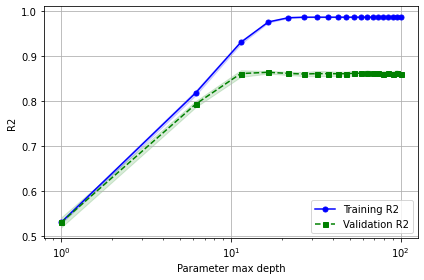

In [29]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_dt.png', dpi=300)
plt.show()

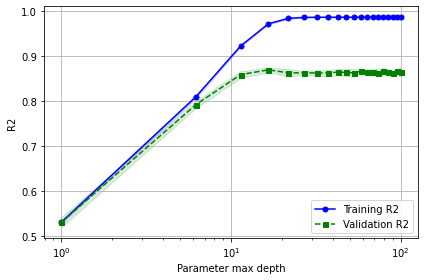

In [30]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train_v, 
                                             y=y_train_v, param_name='max_depth', 
                                             param_range=param_range, scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_dt_v.png', dpi=300)
plt.show()

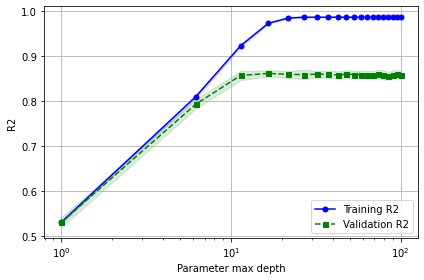

In [31]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train_sbs, y=y_train,
                                             param_name='max_depth', param_range=param_range, scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_dt_sbs.png', dpi=300)
plt.show()

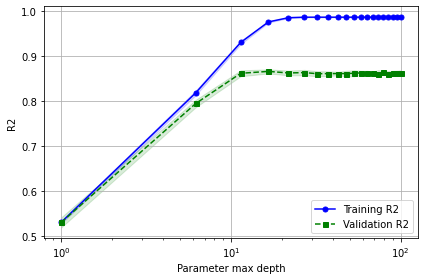

In [32]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), 
                                             X=X_train_pca, y=y_train_pca, param_name='max_depth',
                                             param_range=param_range, scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('vc_dt_pca.png', dpi=300)
plt.show()

#### Random Forest

In [33]:
forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=15,
                               random_state=1, n_jobs=-1)
rf = result(forest, X_train, X_test, np.ravel(y_train), y_test)
print('ALL','\nTRAIN R2:', rf[0], 'TEST R2:', rf[1],'\nTRAIN MSE:', rf[2], 
      'TEST MSE:', rf[3], '\nTRAIN RMSE:', rf[4], 'TEST RMSE:', rf[5], 
      '\nRunning Time:', rf[6])

rf_v = result(forest, X_train_v, X_test_v, np.ravel(y_train_v), y_test_v)
print('VARIANCE','\nTRAIN R2:', rf_v[0], 'TEST R2:', rf_v[1],'\nTRAIN MSE:', rf_v[2], 
      'TEST MSE:', rf_v[3], '\nTRAIN RMSE:', rf_v[4], 'TEST RMSE:', rf_v[5], 
      '\nRunning Time:', rf_v[6])
rf_sbs = result(forest, X_train_sbs, X_test_sbs, np.ravel(y_train), y_test)
print('SBS','\nTRAIN R2:', rf_sbs[0], 'TEST R2:', rf_sbs[1],'\nTRAIN MSE:', rf_sbs[2], 
      'TEST MSE:', rf_sbs[3], '\nTRAIN RMSE:', rf_sbs[4], 'TEST RMSE:', rf_sbs[5], 
      '\nRunning Time:', rf_sbs[6])
rf_pca = result(forest, X_train_pca, X_test_pca, np.ravel(y_train_pca), y_test_pca)
print('PCA','\nTRAIN R2:', rf_pca[0], 'TEST R2:', rf_pca[1],'\nTRAIN MSE:', rf_pca[2], 
      'TEST MSE:', rf_pca[3], '\nTRAIN RMSE:', rf_pca[4], 'TEST RMSE:', rf_pca[5], 
      '\nRunning Time:', rf_pca[6])

ALL 
TRAIN R2: 0.9718414469319165 TEST R2: 0.9176481569595136 
TRAIN MSE: 34.05018537863808 TEST MSE: 91.30875512058228 
TRAIN RMSE: 5.835253668748093 TEST RMSE: 9.555561475945947 
Running Time: 20.419057607650757
VARIANCE 
TRAIN R2: 0.9688590315172059 TEST R2: 0.9138125750120641 
TRAIN MSE: 37.63964120879294 TEST MSE: 93.64487281217939 
TRAIN RMSE: 6.135115419353815 TEST RMSE: 9.677028098139397 
Running Time: 13.871877670288086
SBS 
TRAIN R2: 0.9699397931729508 TEST R2: 0.9130996878935262 
TRAIN MSE: 36.65410506610075 TEST MSE: 88.54374375323862 
TRAIN RMSE: 6.054263379313849 TEST RMSE: 9.409768528143433 
Running Time: 6.990294933319092
PCA 
TRAIN R2: 0.971849464197913 TEST R2: 0.9178882642944481 
TRAIN MSE: 0.028969496190439502 TEST MSE: 0.07807617427238528 
TRAIN RMSE: 0.17020427782649736 TEST RMSE: 0.2794211414198741 
Running Time: 18.022820949554443


Validation curve

In [34]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(),
                                             X=X_train, y=np.ravel(y_train), scoring='r2',
                                             param_name='max_depth', param_range=param_range, cv=5)

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('VC_rf.png', dpi=300)
plt.show()

KeyboardInterrupt: 

In [ ]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(),
                                             X=X_train_v, y=np.ravel(y_train_v), scoring='r2',
                                             param_name='max_depth', param_range=param_range, cv=5)

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('VC_rf_v.png', dpi=300)
plt.show()

In [ ]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(),
                                             X=X_train_sbs, y=np.ravel(y_train), scoring='r2',
                                             param_name='max_depth', param_range=param_range, cv=5)

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('VC_rf_sbs.png', dpi=300)
plt.show()

In [ ]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(),
                                             X=X_train_pca, y=np.ravel(y_train_pca), scoring='r2',
                                             param_name='max_depth', param_range=param_range, cv=5)

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig('VC_rf_pca.png', dpi=300)
plt.show()

#### XGBoost Regressor

In [ ]:
boost = XGBRegressor(n_estimators=374, eta = 0.02, max_depth = 15, subsample = 0.50)

xgb = result(boost, X_train, X_test, y_train, y_test)
print('ALL','\nTRAIN R2:', xgb[0], 'TEST R2:', xgb[1],'\nTRAIN MSE:', xgb[2], 
      'TEST MSE:', xgb[3], '\nTRAIN RMSE:', xgb[4], 'TEST RMSE:', xgb[5], 
      '\nRunning Time:', xgb[6])
xgb_v = result(boost, X_train_v, X_test_v, y_train_v, y_test_v)
print('VARIANCE','\nTRAIN R2:', xgb_v[0], 'TEST R2:', xgb_v[1],'\nTRAIN MSE:', xgb_v[2], 
      'TEST MSE:', xgb_v[3], '\nTRAIN RMSE:', xgb_v[4], 'TEST RMSE:', xgb_v[5], 
      '\nRunning Time:', xgb_v[6])
xgb_sbs = result(boost, X_train_sbs, X_test_sbs, y_train, y_test)
print('SBS','\nTRAIN R2:', xgb_sbs[0], 'TEST R2:', xgb_sbs[1],'\nTRAIN MSE:', xgb_sbs[2], 
      'TEST MSE:', xgb_sbs[3], '\nTRAIN RMSE:', xgb_sbs[4], 'TEST RMSE:', xgb_sbs[5], 
      '\nRunning Time:', xgb_sbs[6])
xgb_pca = result(boost, X_train_pca, X_test_pca, np.ravel(y_train_pca), y_test_pca)
print('PCA','\nTRAIN R2:', rf_pca[0], 'TEST R2:', rf_pca[1],'\nTRAIN MSE:', rf_pca[2], 
      'TEST MSE:', rf_sbs[3], '\nTRAIN RMSE:', rf_pca[4], 'TEST RMSE:', rf_pca[5], 
      '\nRunning Time:', rf_pca[6])

Grid Search

In [ ]:
param_grid = [{'n_estimators': [300, 350, 400], 'eta': [0.001,0.01,0.02, 0.1], 'max_depth':[10,15,20],
               'subsample': [0.3, 0.5, 0.7]}]
gs = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='r2', refit=True, cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

### Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=2)

X_poly_train, X_poly_test  = poly.fit_transform(X_train), poly.fit_transform(X_test)
X_poly_train_v, X_poly_test_v = poly.fit_transform(X_train_v), poly.fit_transform(X_test_v) 
X_poly_train_sbs, X_poly_test_sbs = poly.fit_transform(X_train_sbs), poly.fit_transform(X_test_sbs)
X_poly_train_pca, X_poly_test_pca = poly.fit_transform(X_train_pca), poly.fit_transform(X_test_pca)

In [17]:
poly= result(LinearRegression(), X_poly_train, X_poly_test, y_train, y_test)
print('ALL','\nTRAIN R2:', poly[0], 'TEST R2:', poly[1],'\nTRAIN MSE:', poly[2], 
      'TEST MSE:', poly[3], '\nTRAIN RMSE:', poly[4], 'TEST RMSE:', poly[5], 
      '\nRunning Time:', poly[6])

poly_v = result(LinearRegression(), X_poly_train_v, X_poly_test_v, y_train, y_test)
print('VARIANCE','\nTRAIN R2:', poly_v[0], 'TEST R2:', poly_v[1],'\nTRAIN MSE:', poly_v[2], 
      'TEST MSE:', poly_v[3], '\nTRAIN RMSE:', poly_v[4], 'TEST RMSE:', poly_v[5], 
      '\nRunning Time:', poly_v[6])
poly_sbs = result(LinearRegression(), X_poly_train_sbs, X_poly_test_sbs, y_train, y_test)
print('SBS','\nTRAIN R2:', poly_sbs[0], 'TEST R2:', poly_sbs[1],'\nTRAIN MSE:', poly_sbs[2], 
      'TEST MSE:', poly_sbs[3], '\nTRAIN RMSE:', poly_sbs[4], 'TEST RMSE:', poly_sbs[5], 
      '\nRunning Time:', poly_sbs[6])
poly_pca = result(LinearRegression(), X_poly_train_pca, X_poly_test_pca, y_train, y_test)
print('PCA','\nTRAIN R2:', poly_pca[0], 'TEST R2:', poly_pca[1],'\nTRAIN MSE:', poly_pca[2], 
      'TEST MSE:', poly_pca[3], '\nTRAIN RMSE:', poly_pca[4], 'TEST RMSE:', poly_pca[5], 
      '\nRunning Time:', poly_pca[6])

ALL 
TRAIN R2: 0.9147923910831969 TEST R2: -0.228195350842939 
TRAIN MSE: 106.70518255868109 TEST MSE: 354.8942612567566 
TRAIN RMSE: 10.329820064196719 TEST RMSE: 18.83863745754338 
Running Time: 39.013110399246216
VARIANCE 
TRAIN R2: 0.8702802662126571 TEST R2: 0.817505287678648 
TRAIN MSE: 155.79028101752132 TEST MSE: 214.20314086246407 
TRAIN RMSE: 12.481597694907544 TEST RMSE: 14.635680403126603 
Running Time: 6.261765003204346
SBS 
TRAIN R2: 0.8346191734489355 TEST R2: 0.823317227015252 
TRAIN MSE: 195.66687176303472 TEST MSE: 215.60556463667035 
TRAIN RMSE: 13.988097503343145 TEST RMSE: 14.683513361476889 
Running Time: 0.9900848865509033
PCA 
TRAIN R2: 0.9147943938858933 TEST R2: -0.23481653473945246 
TRAIN MSE: 106.70473352476412 TEST MSE: 355.07923846480213 
TRAIN RMSE: 10.329798329336548 TEST RMSE: 18.843546334615525 
Running Time: 33.997599840164185
